# Project

Dataset: 
- https://www.kaggle.com/datasets/andrewmvd/medical-mnist

Project Idea: 
- The dataset consists of 58954 images divided into 6 categories [AbdomenCT, BreastMRI, CXR, ChestCT, Hand, HeadCT]
- This project will test different neural networks that vary in complexity:
    - model_simple: the simplest neural network consists of only 3 layers
    - model_medium: extends the model_simple further
    - model_complex: has residual connections
    - model_resnet: transfer learning with ResNet
- Furthermore, the number of samples will be reduced per class
    - Assumption: If there is less data, simpler networks achieve better results. Since overfitting is more likely to occur with a complex neural network and insufficient data.

# GPU Check

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
print(tf.test.is_built_with_cuda()) +
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libaries

In [2]:
#! pip install split-folders

In [3]:
import numpy as np 
import pandas as pd 
import os
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import zipfile
import splitfolders

# Machine Learning Specifications

## Parameter Settings

In [4]:
batch_size = 256
epochs = 30
lr = 0.001

img_height = 64
img_width = 64
img_channels = 3
img_size = (img_height, img_width)
img_shape = (img_height, img_width, img_channels)

optimizer = 'adam'
loss ='categorical_crossentropy'
metrics = ['accuracy']

## Callbacks

In [5]:
def get_callbacks(model_path):
  checkpoint = callbacks.ModelCheckpoint(model_path,
                              monitor='val_accuracy',
                              mode='max',
                              save_best_only = True,
                              verbose=0)

  earlystop = callbacks.EarlyStopping(monitor = 'val_accuracy', 
                            min_delta = 0, 
                            patience = 3,
                            verbose = 0)

  learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                              patience=2, 
                                              verbose=0, 
                                              factor=0.2, 
                                              min_lr=0.00001)
  
  return [checkpoint, earlystop, learning_rate_reduction]

## Helper Functions

In [6]:
def plot_history(history, figsize=(8, 6)):
  plt.figure(figsize=figsize)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training history')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  plt.figure(figsize=figsize)
  if 'accuracy' in history.history.keys():
      plt.plot(history.history['accuracy'])
  elif 'acc' in history.history.keys():
      plt.plot(history.history['acc'])
  if 'val_accuracy' in history.history.keys():
      plt.plot(history.history['val_accuracy'])
  elif 'val_acc' in history.history.keys():
      plt.plot(history.history['val_acc'])
  plt.title('Training history')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [7]:
def train_model(model, model_name, train_gen, val_gen):
  callbacks = get_callbacks(model_name)
  history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = epochs,
    callbacks = callbacks
  )

  plot_history(history)

  return history

In [8]:
def test_model(model, test_gen, no_classes):
  y_pred = model.predict(test_gen)
  y_true = test_gen.labels

  y_pred = np.argmax(y_pred, axis=1)
  cfTable = confusion_matrix(y_true, y_pred, labels=range(no_classes))

  figsize = (12,12)
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true', ax=plt.subplots(figsize=figsize)[1])
  plt.show()

  figsize = (12,12)
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', ax=plt.subplots(figsize=figsize)[1])
  plt.show()

  print('\n')
  
  TPRs = pd.Series(0., index=range(no_classes))
  
  for cl in range(no_classes):
      print('Class %s:'%(cl))
      others = list(set(list(range(cfTable.shape[0]))) - set([cl]))
      tp = cfTable[cl, cl]
      tn = np.sum(cfTable[others, :][:, others])
      fp = np.sum(cfTable[others, :][:, [cl]])
      fn = np.sum(cfTable[[cl], :][:, others])
      tpr = tp / (tp + fn)
      tnr = tn / (tn + fp)
      prec = tp / (tp + fp)
      TPRs[cl] = tpr
      print('    Sensitivity (TPR): %7.3f%% (%d of %d)'%(100. * tpr, tp, tp + fn)) 
      print('    Specificity (TNR): %7.3f%% (%d of %d)'%(100. * tnr, tn, tn + fp)) 
      print('    Precision:         %7.3f%% (%d of %d)'%(100. * prec, tp, tp + fp))
      print('    Neg. pred. value:  %7.3f%% (%d of %d)'%(100. * tn / (tn + fn) , tn, tn + fn))
  
  print('\nOverall accuracy:  %7.3f%% (%d of %d)'%(np.sum(np.diagonal(cfTable)) * 100. / len(y_true),
        np.sum(np.diagonal(cfTable)), len(y_true)))
  print('Balanced accuracy: %7.3f%%'%(np.mean(TPRs) * 100.))

# Prepare Data

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls '/content/drive/My Drive'

In [10]:
import zipfile

#base_dir = '/content/drive/My Drive/AKT3/'
base_dir = './'
zip_dir =  base_dir + 'archive.zip'
data_dir = base_dir + 'dataset'

if (not os.path.exists(data_dir)):
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(base_dir)
  print('all data has been unzipped')
else:
  print('the data is already unzipped')

the data is already unzipped


In [11]:
output_dir = base_dir + 'splitted_data/'

if (not os.path.exists(output_dir)):
  splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(0.7, 0.15, 0.15)) 

Copying files: 600 files [00:01, 381.92 files/s]


### Helper Functions

In [12]:
def get_generator(transfer_flag, preproc=None):
  image_data_gen = ImageDataGenerator(rescale = 1./255)  
  
  if transfer_flag:
    image_data_gen.preprocessing_function = preproc
  
  return image_data_gen

def get_data_from_gen(gen, dir, shuffle = True):
  return gen.flow_from_directory(
    dir,
    seed=123,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = shuffle)

In [13]:
def visualize_images(gen, class_names):
  images, labels = next(gen)

  plt.figure(figsize=(10, 10))

  for img, lbl, i in zip(images, labels, range(9)):
    lbl = list(lbl)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[lbl.index(1)])
    plt.axis("off")


# Models

In [14]:
def get_model_simple(num_classes):
  model = Sequential([
    tf.keras.Input(shape=img_shape),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(loss = loss, optimizer=optimizer, metrics=metrics)
  return model

In [15]:
def get_model_medium(num_classes):
  model = Sequential([
    tf.keras.Input(shape=img_shape),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding= 'same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding= 'same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(loss = loss, optimizer=optimizer, metrics=metrics)
  return model

In [16]:
def get_model_complex(num_classes):
  inputs = tf.keras.Input(shape=img_shape)

  # block 1
  x = layers.Conv2D(32, 3, activation='relu', name='block_1_conv_1')(inputs)
  x = layers.Conv2D(64, 3, activation='relu', name='block_1_conv_2')(x)
  block_1_output = layers.MaxPooling2D(3, name='block_1_maxpool')(x)

  #Block 2
  x = layers.Conv2D(64, 3, activation='relu', padding='same', name='block_2_conv_1')(block_1_output)
  x = layers.Conv2D(64, 3, activation='relu', padding='same', name='block_2_conv_2')(x)
  block_2_output = layers.add([x, block_1_output], name='block_1_add_block_2')

  #Block 3
  x = layers.Conv2D(64, 3, activation='relu', padding='same', name='block_3_conv_1')(block_2_output)
  x = layers.Conv2D(64, 3, activation='relu', padding='same', name='block_3_conv_2')(x)
  block_3_output = layers.add([x, block_2_output], name='block_2_add_block_3')


  #Network tail
  x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs, name='mini_resnet')

  model.compile(loss = loss, optimizer=optimizer, metrics=metrics)
  return model

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

def get_model_resnet(num_classes):
  pre_model = ResNet50(input_shape=img_shape,
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')
  pre_model.trainable = False

  inputs = pre_model.input
  x = layers.Dense(100, activation='relu')(pre_model.output)
  x = layers.Dense(100, activation='relu')(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(loss = loss, optimizer=optimizer, metrics=metrics)
  return model

# Whole Dataset (~ 10000 images per class) 

### Load Data

In [30]:
image_data_gen = get_generator(False)
image_data_gen_preproc = get_generator(True, preprocess_input)

In [31]:
train_dir = './splitted_data_1/train'
val_dir   = './splitted_data_1/val'
test_dir  = './splitted_data_1/test'

In [32]:
train_gen = get_data_from_gen(image_data_gen, train_dir)
val_gen   = get_data_from_gen(image_data_gen, val_dir, False)
test_gen  = get_data_from_gen(image_data_gen, test_dir, False)

train_gen_preproc = get_data_from_gen(image_data_gen_preproc, train_dir)
val_gen_preproc   = get_data_from_gen(image_data_gen_preproc, val_dir, False)
test_gen_preproc  = get_data_from_gen(image_data_gen_preproc, test_dir, False)

Found 35372 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.
Found 11792 images belonging to 6 classes.
Found 35372 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.
Found 11792 images belonging to 6 classes.


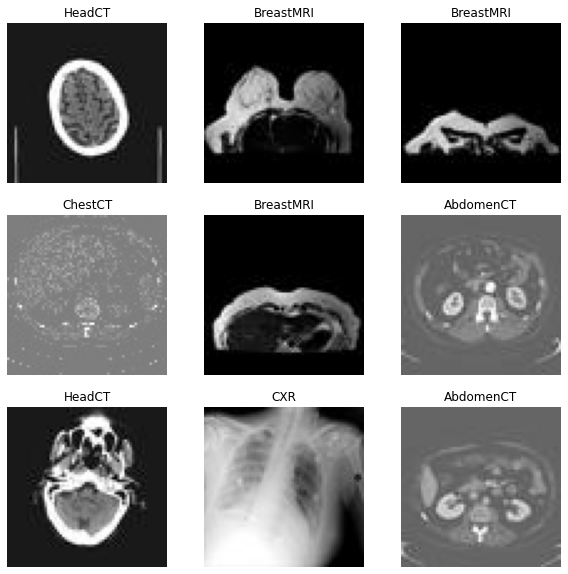

In [21]:
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

visualize_images(train_gen, class_names)

### Model Instantiation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 238144)            0         
_________________________________________________________________
dropout (Dropout)            (None, 238144)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1

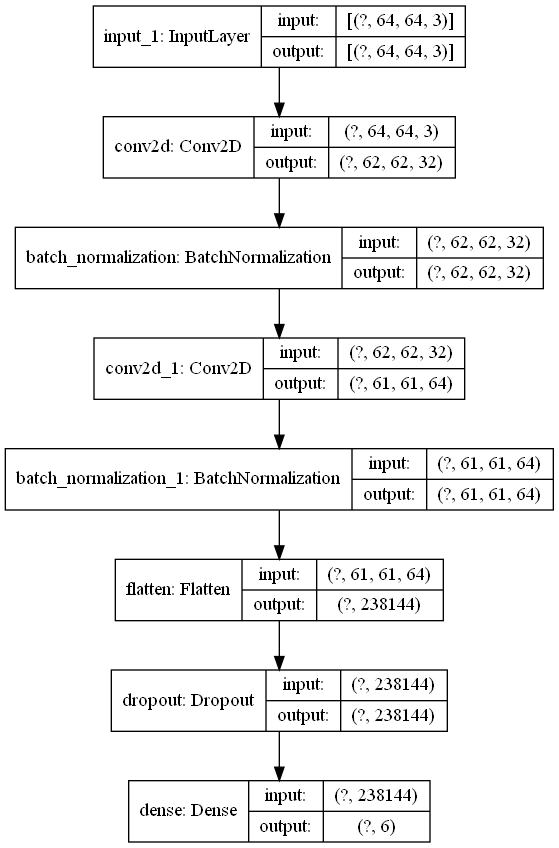

In [22]:
model_simple_name = 'model_simple.h5'
model_simple = get_model_simple(num_classes)
model_simple.summary()
tf.keras.utils.plot_model(model_simple, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

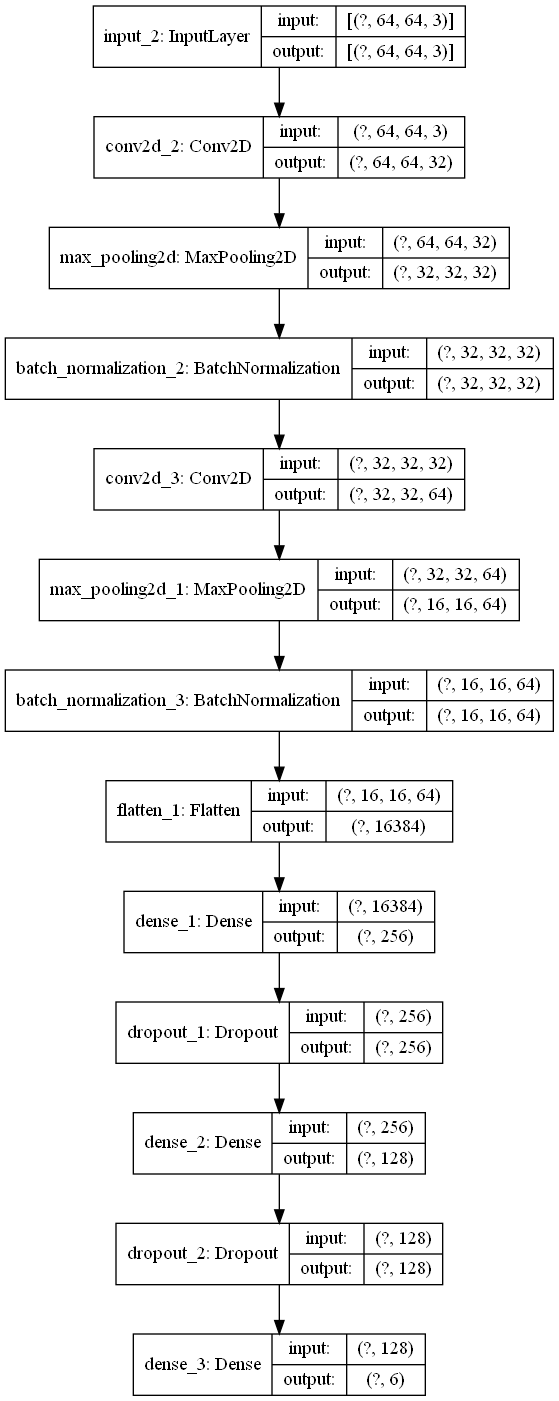

In [23]:
model_medium_name = 'model_medium.h5'
model_medium = get_model_medium(num_classes)
model_medium.summary()
tf.keras.utils.plot_model(model_medium, show_shapes=True)

Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 62, 62, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
block_1_conv_2 (Conv2D)         (None, 60, 60, 64)   18496       block_1_conv_1[0][0]             
__________________________________________________________________________________________________
block_1_maxpool (MaxPooling2D)  (None, 20, 20, 64)   0           block_1_conv_2[0][0]             
________________________________________________________________________________________

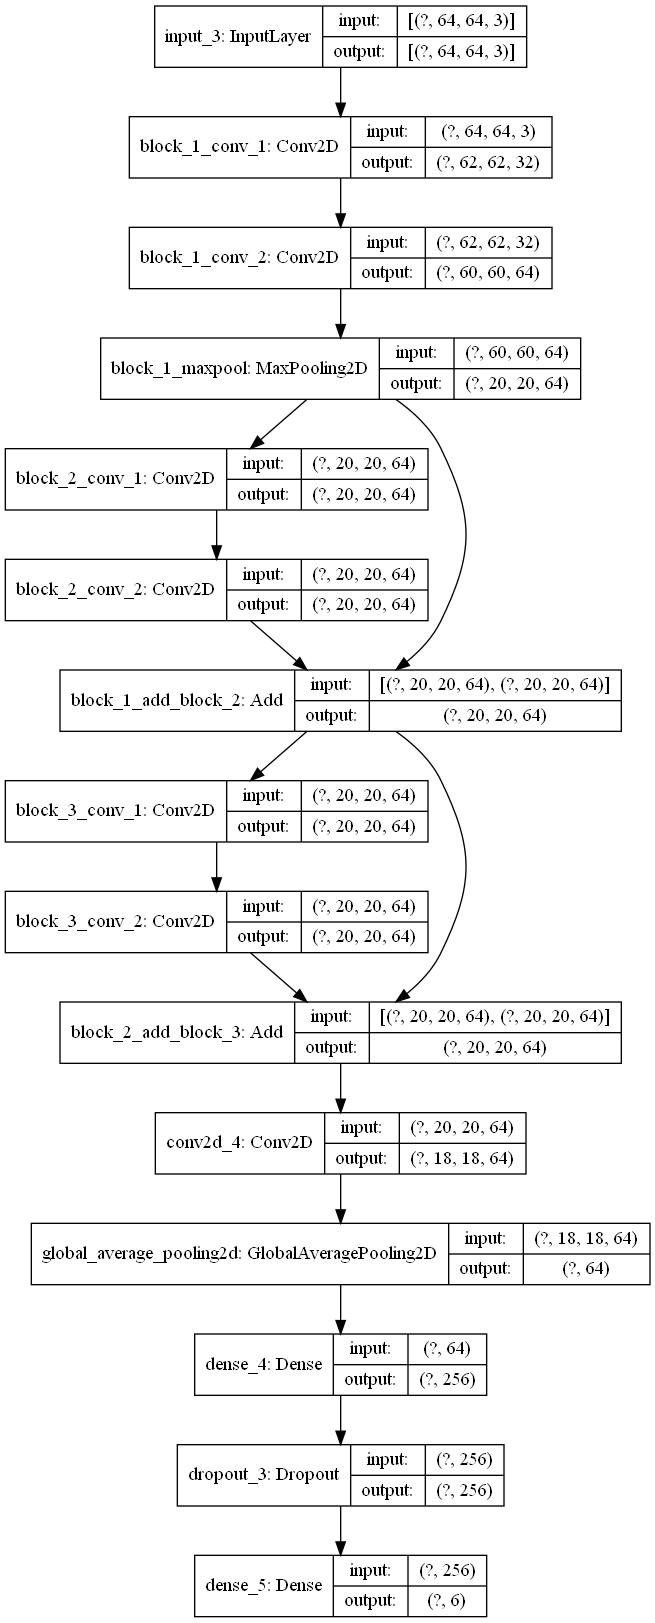

In [24]:
model_complex_name = 'model_complex.h5'
model_complex = get_model_complex(num_classes)
model_complex.summary()
tf.keras.utils.plot_model(model_complex, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

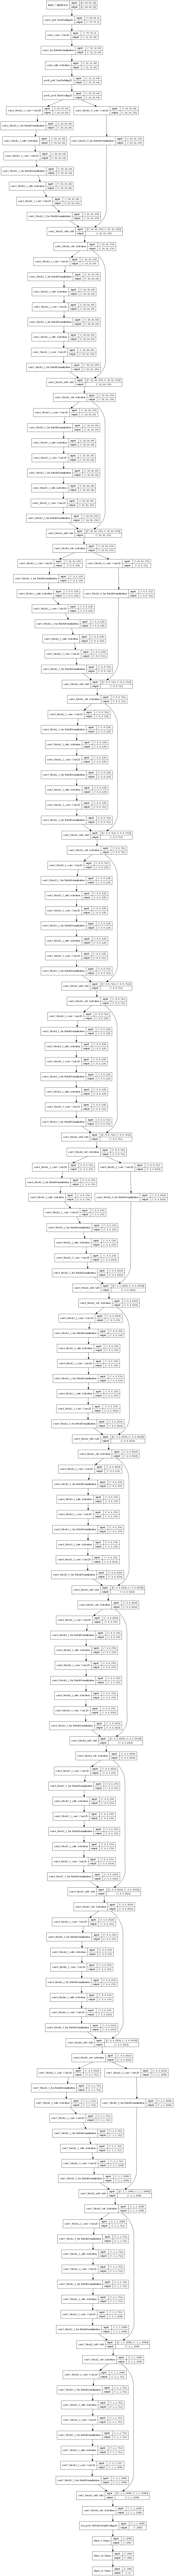

In [35]:
model_resnet_name = 'model_resnet.h5'
model_resnet = get_model_resnet(num_classes)
model_resnet.summary()
tf.keras.utils.plot_model(model_resnet, show_shapes=True)

### Train Model

Epoch 1/30
139/139 [==============================] - 48s 346ms/step - loss: 0.4174 - accuracy: 0.9832 - val_loss: 69.1896 - val_accuracy: 0.1699 - lr: 0.0010
Epoch 2/30
139/139 [==============================] - 33s 236ms/step - loss: 0.1079 - accuracy: 0.9976 - val_loss: 76.3065 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 3/30
139/139 [==============================] - 33s 237ms/step - loss: 0.0636 - accuracy: 0.9988 - val_loss: 5.2792 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 4/30
139/139 [==============================] - 48s 345ms/step - loss: 0.2581 - accuracy: 0.9943 - val_loss: 0.4387 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 5/30
139/139 [==============================] - 34s 245ms/step - loss: 0.0690 - accuracy: 0.9988 - val_loss: 34.4404 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 6/30
139/139 [==============================] - 33s 237ms/step - loss: 0.1870 - accuracy: 0.9962 - val_loss: 125.4903 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 7/30
139/139 [===========================

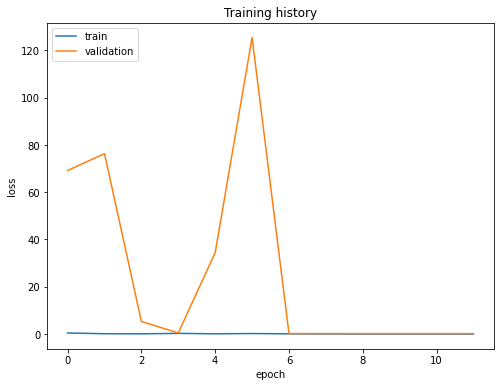

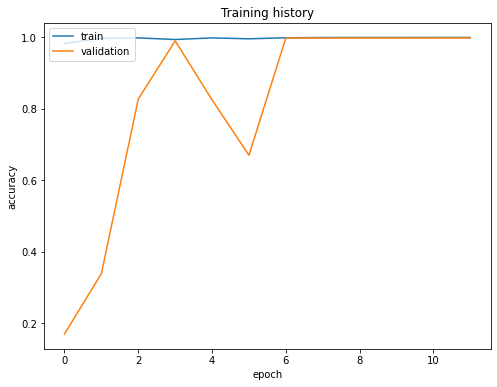

In [26]:
train_model(model_simple, model_simple_name, train_gen, val_gen)

Epoch 1/30
139/139 [==============================] - 48s 348ms/step - loss: 0.1674 - accuracy: 0.9692 - val_loss: 2.4456 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 2/30
139/139 [==============================] - 52s 374ms/step - loss: 0.0300 - accuracy: 0.9948 - val_loss: 0.8263 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 3/30
139/139 [==============================] - 39s 281ms/step - loss: 0.0251 - accuracy: 0.9960 - val_loss: 0.0641 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 4/30
139/139 [==============================] - 42s 300ms/step - loss: 0.0126 - accuracy: 0.9973 - val_loss: 0.0141 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 5/30
139/139 [==============================] - 40s 291ms/step - loss: 0.0266 - accuracy: 0.9958 - val_loss: 0.0042 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 6/30
139/139 [==============================] - 47s 342ms/step - loss: 0.0119 - accuracy: 0.9983 - val_loss: 0.0082 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 7/30
139/139 [==============================] 

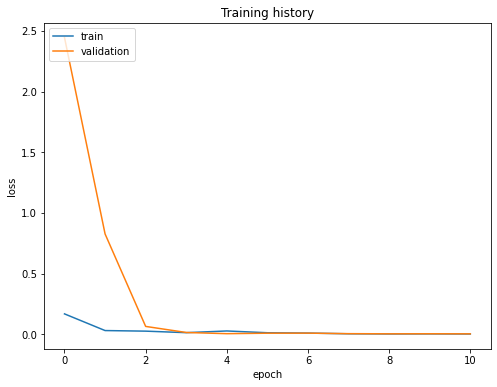

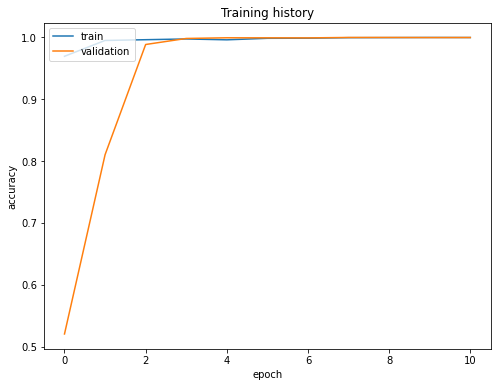

In [27]:
train_model(model_medium, model_medium_name, train_gen, val_gen)

Epoch 1/30
139/139 [==============================] - 38s 270ms/step - loss: 0.6912 - accuracy: 0.6988 - val_loss: 0.1371 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 2/30
139/139 [==============================] - 36s 256ms/step - loss: 0.2523 - accuracy: 0.9287 - val_loss: 0.5908 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 3/30
139/139 [==============================] - 36s 260ms/step - loss: 0.1052 - accuracy: 0.9705 - val_loss: 0.0353 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 4/30
139/139 [==============================] - 37s 267ms/step - loss: 0.0988 - accuracy: 0.9683 - val_loss: 0.0200 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 5/30
139/139 [==============================] - 38s 271ms/step - loss: 0.0493 - accuracy: 0.9854 - val_loss: 0.0226 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 6/30
139/139 [==============================] - 37s 264ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 0.0071 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 7/30
139/139 [==============================] 

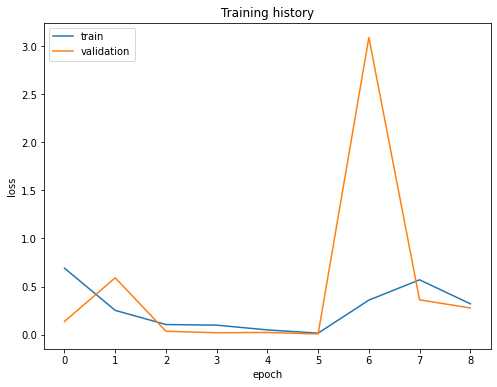

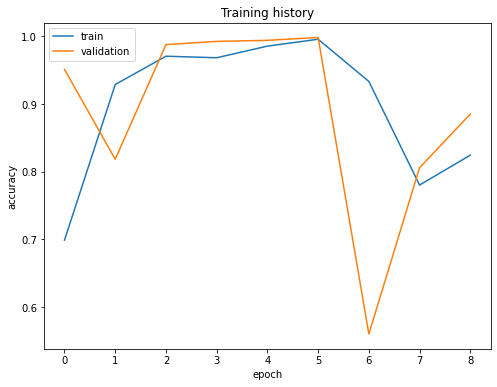

In [28]:
train_model(model_complex, model_complex_name, train_gen, val_gen)

Epoch 1/30
139/139 [==============================] - 49s 352ms/step - loss: 0.7181 - accuracy: 0.8067 - val_loss: 0.2566 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 2/30
139/139 [==============================] - 39s 283ms/step - loss: 0.1992 - accuracy: 0.9355 - val_loss: 0.1675 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 3/30
139/139 [==============================] - 49s 356ms/step - loss: 0.1421 - accuracy: 0.9499 - val_loss: 0.1189 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 4/30
139/139 [==============================] - 39s 279ms/step - loss: 0.1162 - accuracy: 0.9588 - val_loss: 0.1036 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 5/30
139/139 [==============================] - 45s 323ms/step - loss: 0.0961 - accuracy: 0.9666 - val_loss: 0.0842 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 6/30
139/139 [==============================] - 56s 402ms/step - loss: 0.0873 - accuracy: 0.9689 - val_loss: 0.0755 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 7/30
139/139 [==============================] 

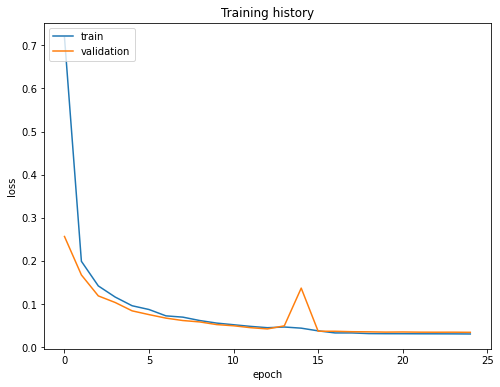

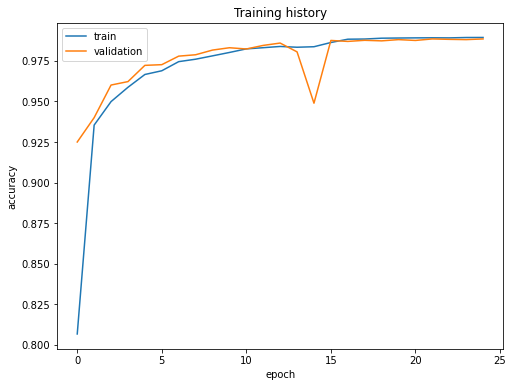

In [36]:
train_model(model_resnet, model_resnet_name, train_gen_preproc, val_gen_preproc)

### Test Model

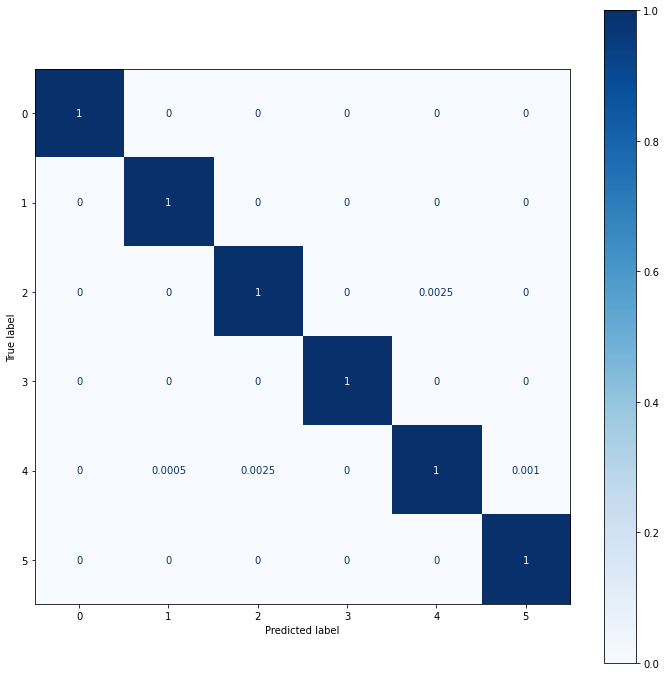

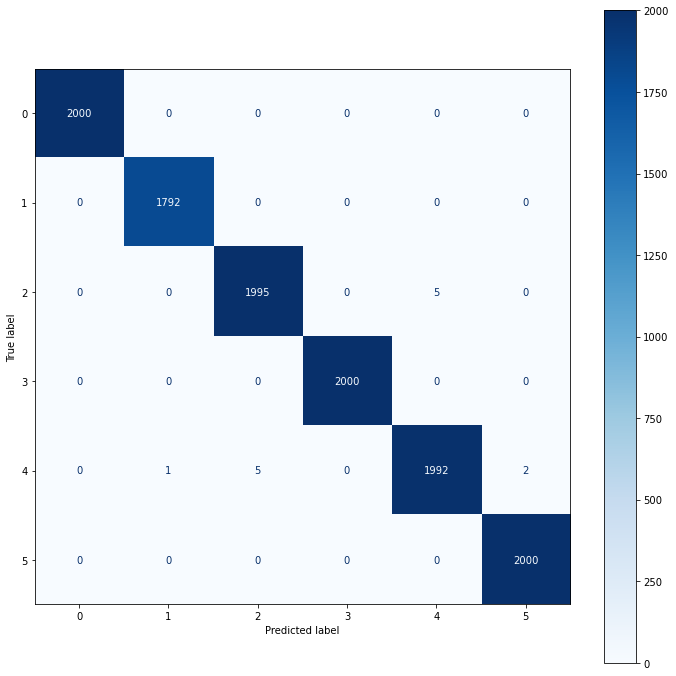



Class 0:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (2000 of 2000)
    Neg. pred. value:  100.000% (9792 of 9792)
Class 1:
    Sensitivity (TPR): 100.000% (1792 of 1792)
    Specificity (TNR):  99.990% (9999 of 10000)
    Precision:          99.944% (1792 of 1793)
    Neg. pred. value:  100.000% (9999 of 9999)
Class 2:
    Sensitivity (TPR):  99.750% (1995 of 2000)
    Specificity (TNR):  99.949% (9787 of 9792)
    Precision:          99.750% (1995 of 2000)
    Neg. pred. value:   99.949% (9787 of 9792)
Class 3:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (2000 of 2000)
    Neg. pred. value:  100.000% (9792 of 9792)
Class 4:
    Sensitivity (TPR):  99.600% (1992 of 2000)
    Specificity (TNR):  99.949% (9787 of 9792)
    Precision:          99.750% (1992 of 1997)
    Neg. pred. value:   99.918% (9787 of 9795)
Class 5:
   

In [37]:
best_model = tf.keras.models.load_model(model_simple_name)
test_model(best_model, test_gen, num_classes)

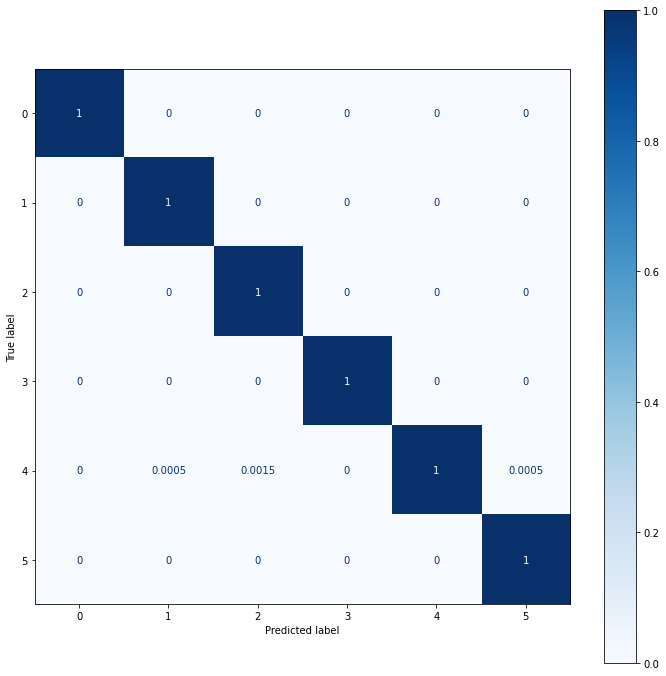

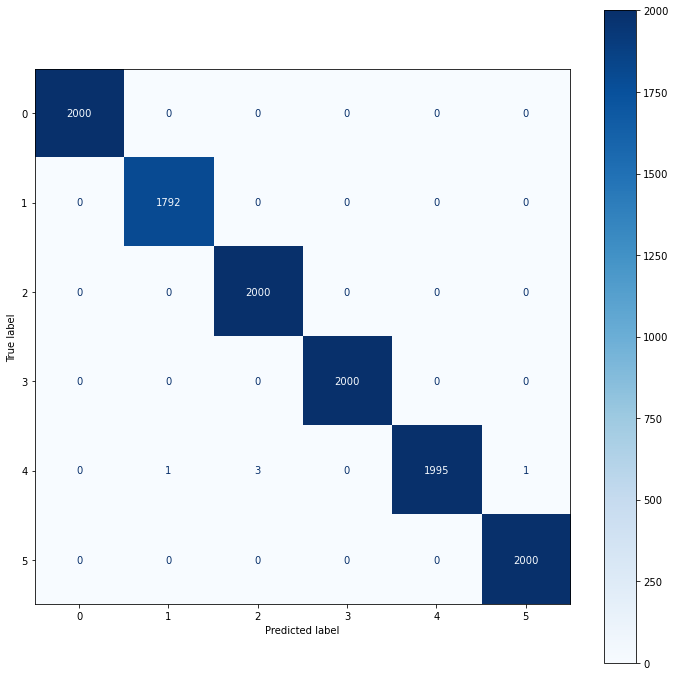



Class 0:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (2000 of 2000)
    Neg. pred. value:  100.000% (9792 of 9792)
Class 1:
    Sensitivity (TPR): 100.000% (1792 of 1792)
    Specificity (TNR):  99.990% (9999 of 10000)
    Precision:          99.944% (1792 of 1793)
    Neg. pred. value:  100.000% (9999 of 9999)
Class 2:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR):  99.969% (9789 of 9792)
    Precision:          99.850% (2000 of 2003)
    Neg. pred. value:  100.000% (9789 of 9789)
Class 3:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (2000 of 2000)
    Neg. pred. value:  100.000% (9792 of 9792)
Class 4:
    Sensitivity (TPR):  99.750% (1995 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (1995 of 1995)
    Neg. pred. value:   99.949% (9792 of 9797)
Class 5:
   

In [38]:
best_model = tf.keras.models.load_model(model_medium_name)
test_model(best_model, test_gen, num_classes)

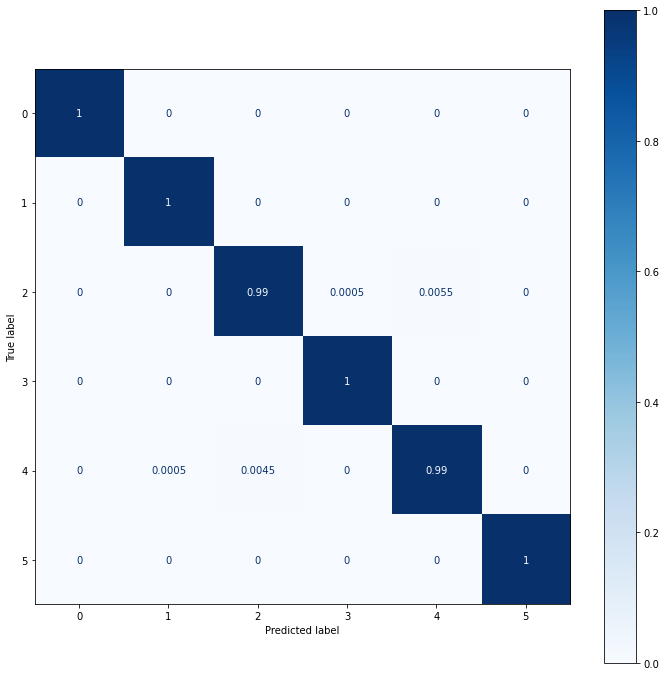

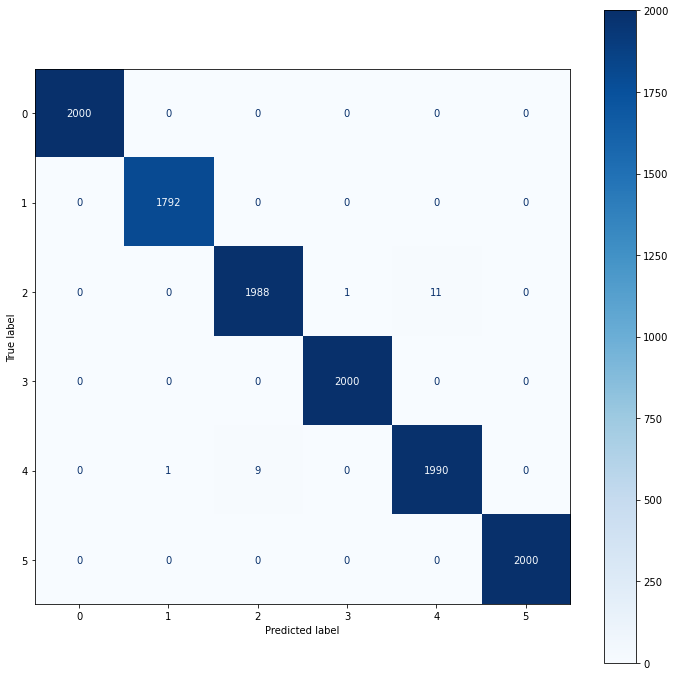



Class 0:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR): 100.000% (9792 of 9792)
    Precision:         100.000% (2000 of 2000)
    Neg. pred. value:  100.000% (9792 of 9792)
Class 1:
    Sensitivity (TPR): 100.000% (1792 of 1792)
    Specificity (TNR):  99.990% (9999 of 10000)
    Precision:          99.944% (1792 of 1793)
    Neg. pred. value:  100.000% (9999 of 9999)
Class 2:
    Sensitivity (TPR):  99.400% (1988 of 2000)
    Specificity (TNR):  99.908% (9783 of 9792)
    Precision:          99.549% (1988 of 1997)
    Neg. pred. value:   99.877% (9783 of 9795)
Class 3:
    Sensitivity (TPR): 100.000% (2000 of 2000)
    Specificity (TNR):  99.990% (9791 of 9792)
    Precision:          99.950% (2000 of 2001)
    Neg. pred. value:  100.000% (9791 of 9791)
Class 4:
    Sensitivity (TPR):  99.500% (1990 of 2000)
    Specificity (TNR):  99.888% (9781 of 9792)
    Precision:          99.450% (1990 of 2001)
    Neg. pred. value:   99.898% (9781 of 9791)
Class 5:
   

In [39]:
best_model = tf.keras.models.load_model(model_complex_name)
test_model(best_model, test_gen, num_classes)

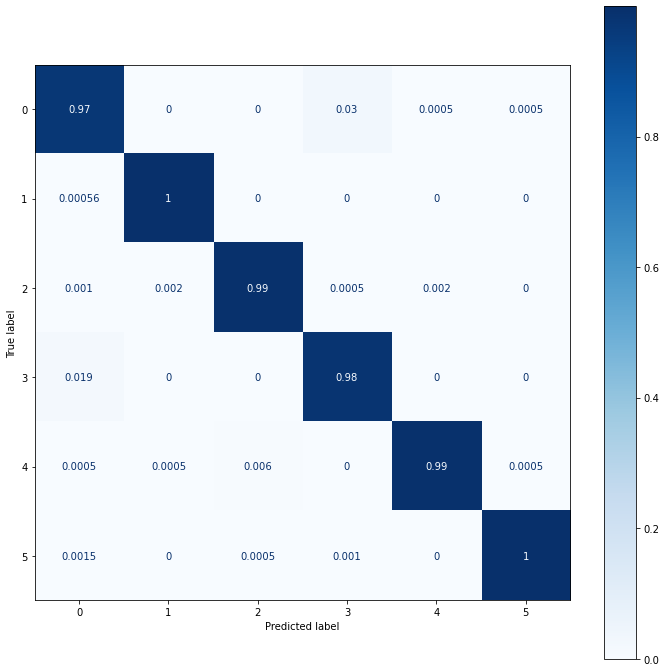

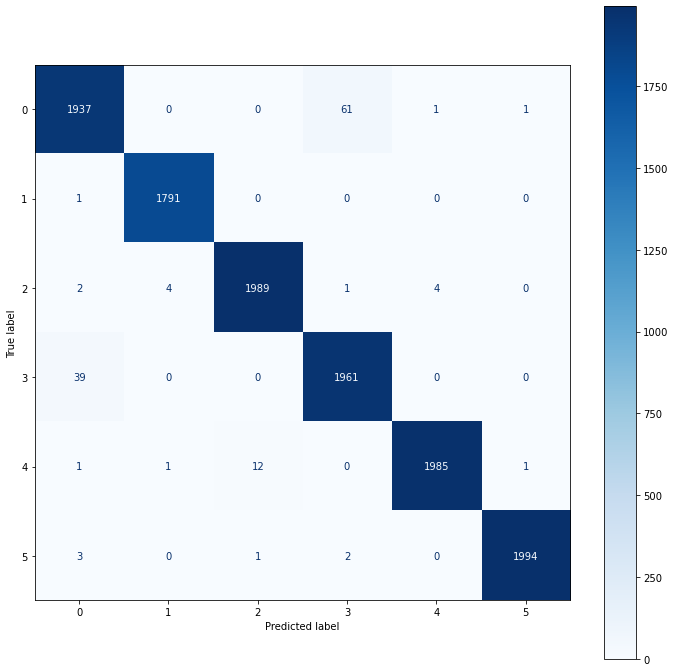



Class 0:
    Sensitivity (TPR):  96.850% (1937 of 2000)
    Specificity (TNR):  99.530% (9746 of 9792)
    Precision:          97.680% (1937 of 1983)
    Neg. pred. value:   99.358% (9746 of 9809)
Class 1:
    Sensitivity (TPR):  99.944% (1791 of 1792)
    Specificity (TNR):  99.950% (9995 of 10000)
    Precision:          99.722% (1791 of 1796)
    Neg. pred. value:   99.990% (9995 of 9996)
Class 2:
    Sensitivity (TPR):  99.450% (1989 of 2000)
    Specificity (TNR):  99.867% (9779 of 9792)
    Precision:          99.351% (1989 of 2002)
    Neg. pred. value:   99.888% (9779 of 9790)
Class 3:
    Sensitivity (TPR):  98.050% (1961 of 2000)
    Specificity (TNR):  99.346% (9728 of 9792)
    Precision:          96.840% (1961 of 2025)
    Neg. pred. value:   99.601% (9728 of 9767)
Class 4:
    Sensitivity (TPR):  99.250% (1985 of 2000)
    Specificity (TNR):  99.949% (9787 of 9792)
    Precision:          99.749% (1985 of 1990)
    Neg. pred. value:   99.847% (9787 of 9802)
Class 5:
   

In [40]:
best_model = tf.keras.models.load_model(model_resnet_name)
test_model(best_model, test_gen_preproc, num_classes)

# Smaller Dataset (4000 images per class) 

### Load Data

In [41]:
train_dir = './splitted_data_2/train'
val_dir   = './splitted_data_2/val'
test_dir  = './splitted_data_2/test'

In [42]:
train_gen = get_data_from_gen(image_data_gen, train_dir)
val_gen   = get_data_from_gen(image_data_gen, val_dir, False)
test_gen  = get_data_from_gen(image_data_gen, test_dir, False )

train_gen_preproc = get_data_from_gen(image_data_gen_preproc, train_dir)
val_gen_preproc   = get_data_from_gen(image_data_gen_preproc, val_dir, False)
test_gen_preproc  = get_data_from_gen(image_data_gen_preproc, test_dir, False )

Found 16800 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 16800 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.


### Train Model

Epoch 1/30
66/66 [==============================] - 108s 2s/step - loss: 0.0502 - accuracy: 0.9996 - val_loss: 0.0706 - val_accuracy: 0.9997 - lr: 1.0000e-05
Epoch 2/30
66/66 [==============================] - 14s 218ms/step - loss: 0.0442 - accuracy: 0.9995 - val_loss: 0.0690 - val_accuracy: 0.9997 - lr: 1.0000e-05
Epoch 3/30
66/66 [==============================] - 14s 216ms/step - loss: 0.0405 - accuracy: 0.9996 - val_loss: 0.0680 - val_accuracy: 0.9997 - lr: 1.0000e-05
Epoch 4/30
66/66 [==============================] - 14s 217ms/step - loss: 0.0388 - accuracy: 0.9995 - val_loss: 0.0668 - val_accuracy: 0.9997 - lr: 1.0000e-05


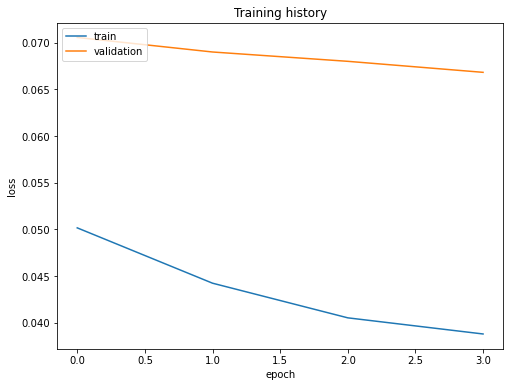

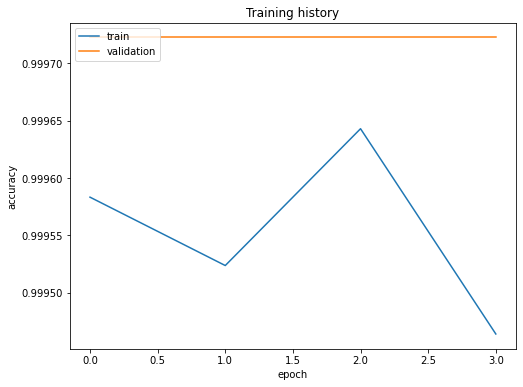

In [43]:
train_model(model_simple, model_simple_name, train_gen, val_gen)

Epoch 1/30
66/66 [==============================] - 11s 170ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0027 - val_accuracy: 0.9997 - lr: 4.0000e-05
Epoch 2/30
66/66 [==============================] - 11s 163ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9997 - lr: 4.0000e-05
Epoch 3/30
66/66 [==============================] - 11s 161ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0037 - val_accuracy: 0.9997 - lr: 4.0000e-05
Epoch 4/30
66/66 [==============================] - 11s 160ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0036 - val_accuracy: 0.9997 - lr: 1.0000e-05


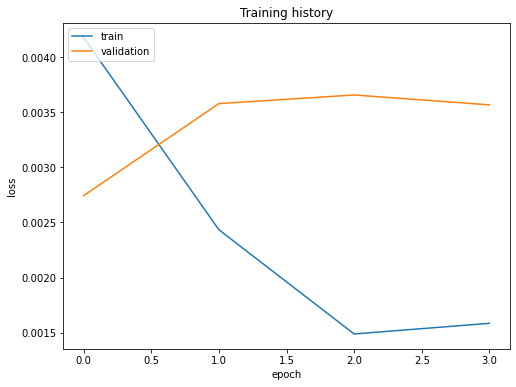

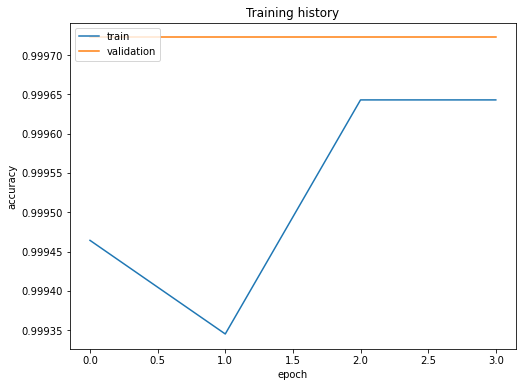

In [44]:
train_model(model_medium, model_medium_name, train_gen, val_gen)

Epoch 1/30
66/66 [==============================] - 16s 249ms/step - loss: 0.2768 - accuracy: 0.8749 - val_loss: 0.2420 - val_accuracy: 0.9386 - lr: 2.0000e-04
Epoch 2/30
66/66 [==============================] - 16s 242ms/step - loss: 0.2346 - accuracy: 0.9283 - val_loss: 0.1687 - val_accuracy: 0.9844 - lr: 2.0000e-04
Epoch 3/30
66/66 [==============================] - 16s 240ms/step - loss: 0.1468 - accuracy: 0.9754 - val_loss: 0.0867 - val_accuracy: 0.9856 - lr: 2.0000e-04
Epoch 4/30
66/66 [==============================] - 16s 241ms/step - loss: 0.0884 - accuracy: 0.9830 - val_loss: 0.0563 - val_accuracy: 0.9875 - lr: 2.0000e-04
Epoch 5/30
66/66 [==============================] - 16s 244ms/step - loss: 0.0714 - accuracy: 0.9842 - val_loss: 0.0521 - val_accuracy: 0.9878 - lr: 2.0000e-04
Epoch 6/30
66/66 [==============================] - 16s 243ms/step - loss: 0.0605 - accuracy: 0.9850 - val_loss: 0.0440 - val_accuracy: 0.9883 - lr: 2.0000e-04
Epoch 7/30
66/66 [======================

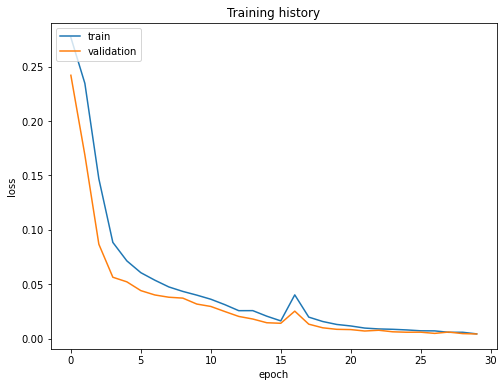

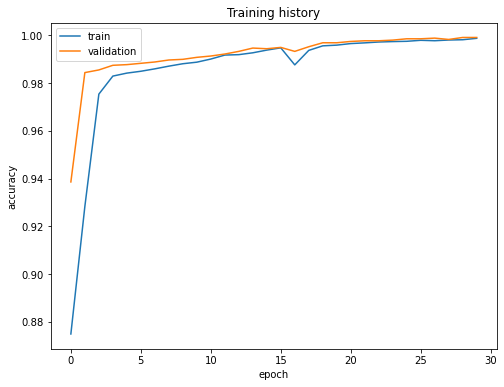

In [45]:
train_model(model_complex, model_complex_name, train_gen, val_gen)

Epoch 1/30
66/66 [==============================] - 45s 680ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0257 - val_accuracy: 0.9911 - lr: 1.0000e-05
Epoch 2/30
66/66 [==============================] - 27s 410ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.0255 - val_accuracy: 0.9914 - lr: 1.0000e-05
Epoch 3/30
66/66 [==============================] - 25s 372ms/step - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0257 - val_accuracy: 0.9911 - lr: 1.0000e-05
Epoch 4/30
66/66 [==============================] - 24s 369ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0253 - val_accuracy: 0.9914 - lr: 1.0000e-05
Epoch 5/30
66/66 [==============================] - 25s 372ms/step - loss: 0.0255 - accuracy: 0.9926 - val_loss: 0.0255 - val_accuracy: 0.9914 - lr: 1.0000e-05


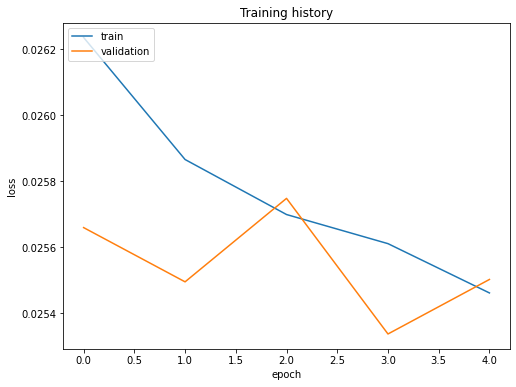

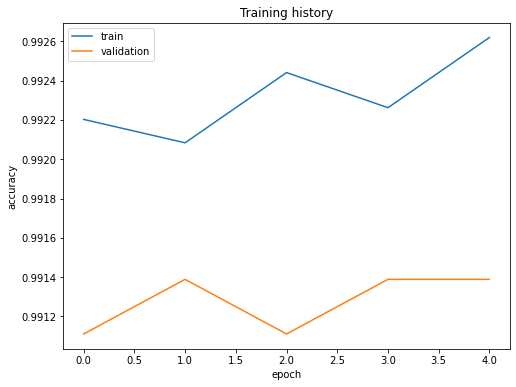

In [47]:
train_model(model_resnet, model_resnet_name, train_gen_preproc, val_gen_preproc)

### Test Model

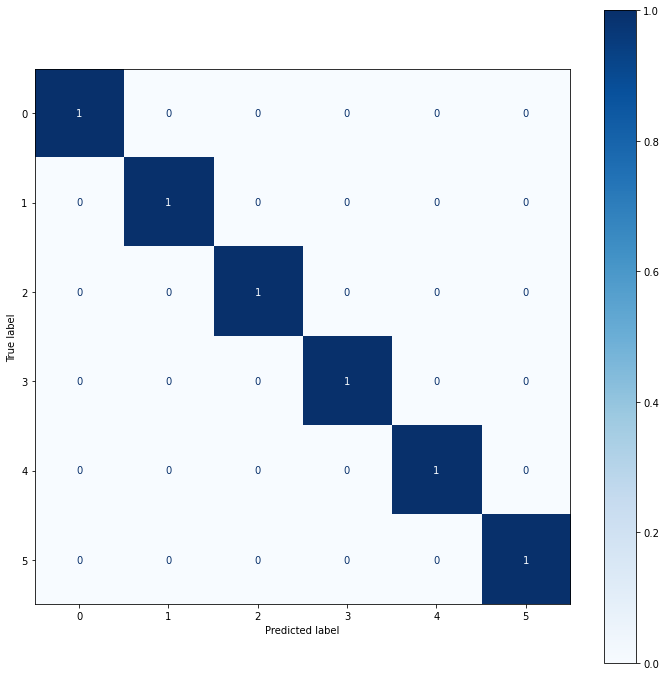

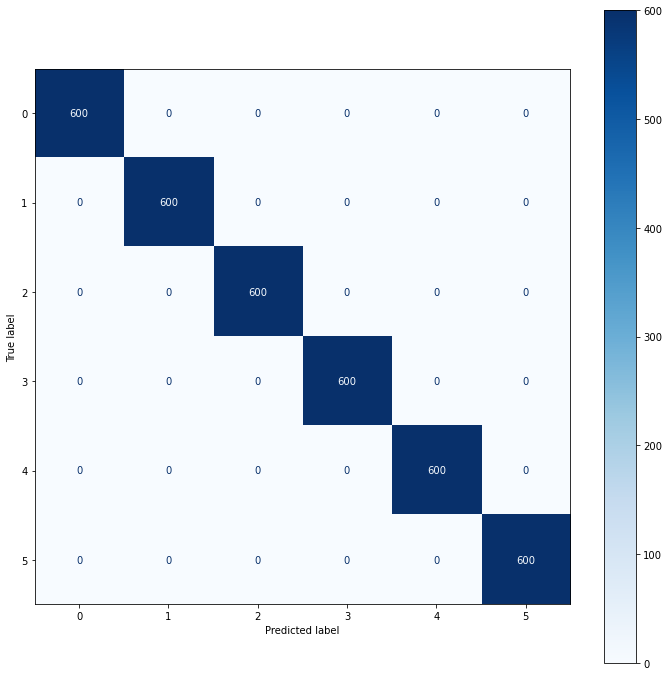



Class 0:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 1:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 2:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 3:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 4:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 5:
    Sensitivity (TPR): 1

In [48]:
best_model = tf.keras.models.load_model(model_simple_name)
test_model(best_model, test_gen, num_classes)

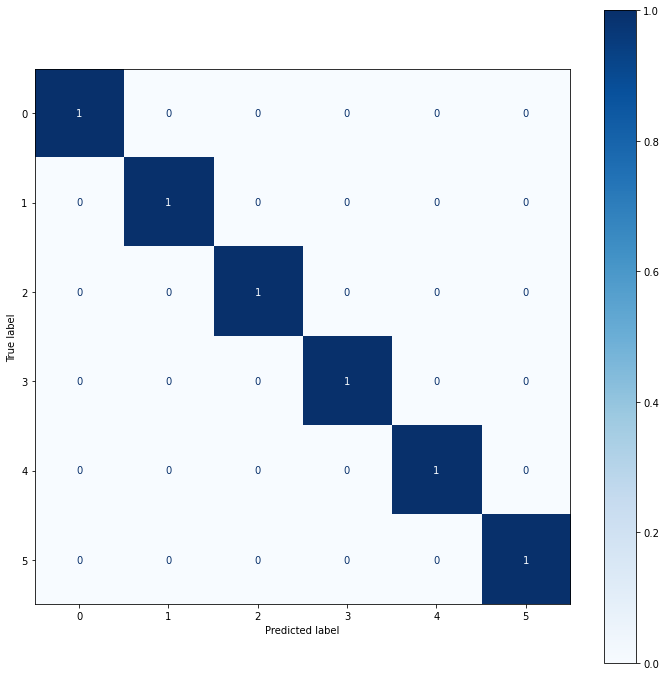

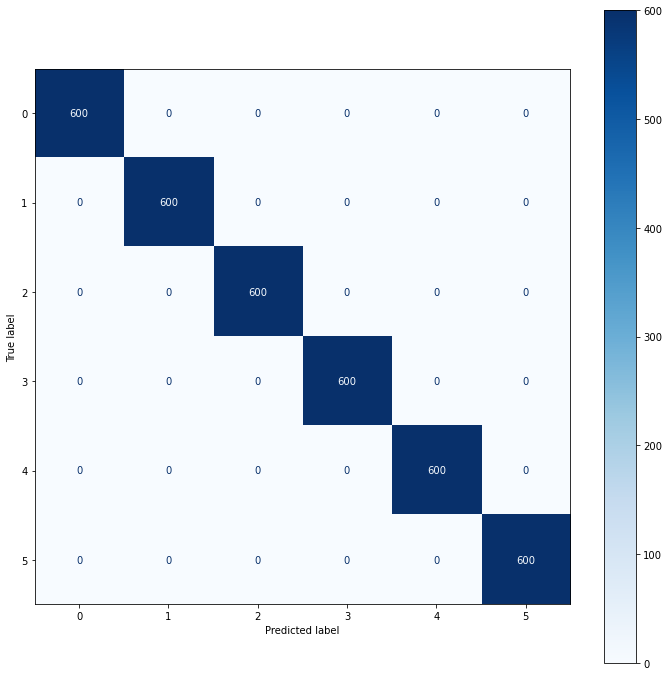



Class 0:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 1:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 2:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 3:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 4:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 5:
    Sensitivity (TPR): 1

In [49]:
best_model = tf.keras.models.load_model(model_medium_name)
test_model(best_model, test_gen, num_classes)

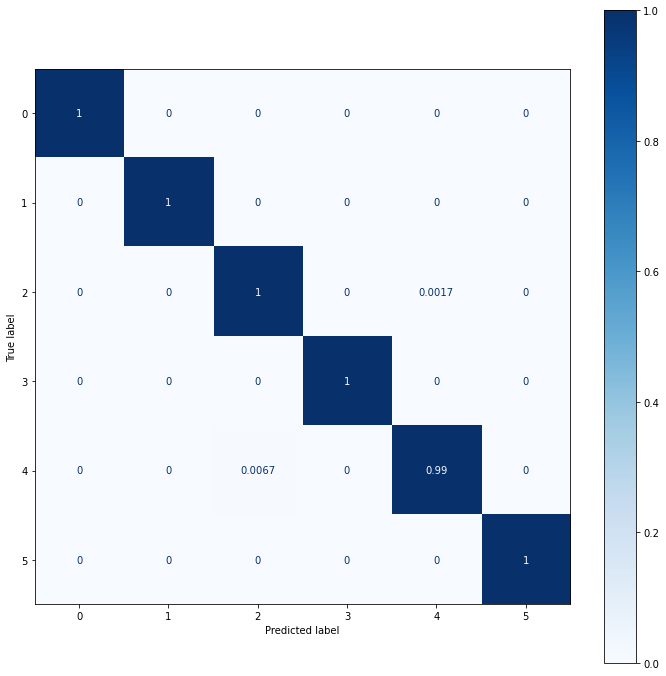

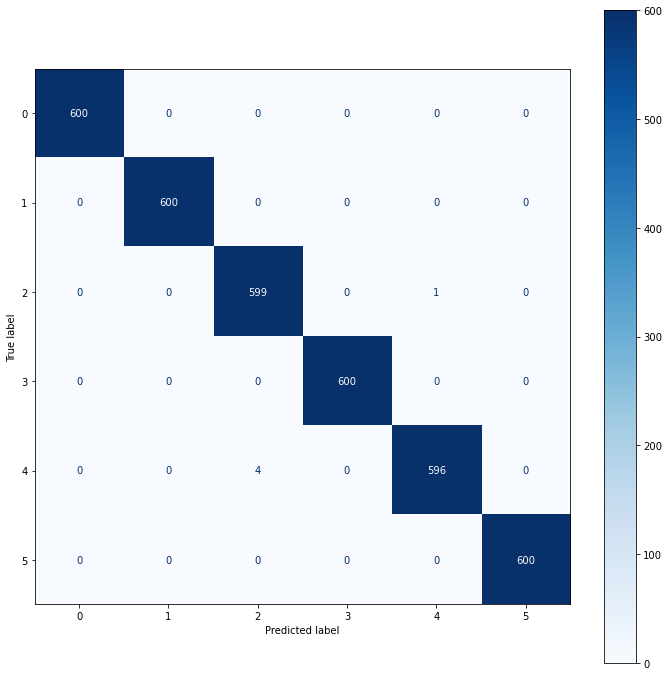



Class 0:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 1:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 2:
    Sensitivity (TPR):  99.833% (599 of 600)
    Specificity (TNR):  99.867% (2996 of 3000)
    Precision:          99.337% (599 of 603)
    Neg. pred. value:   99.967% (2996 of 2997)
Class 3:
    Sensitivity (TPR): 100.000% (600 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (600 of 600)
    Neg. pred. value:  100.000% (3000 of 3000)
Class 4:
    Sensitivity (TPR):  99.333% (596 of 600)
    Specificity (TNR):  99.967% (2999 of 3000)
    Precision:          99.832% (596 of 597)
    Neg. pred. value:   99.867% (2999 of 3003)
Class 5:
    Sensitivity (TPR): 1

In [50]:
best_model = tf.keras.models.load_model(model_complex_name)
test_model(best_model, test_gen, num_classes)

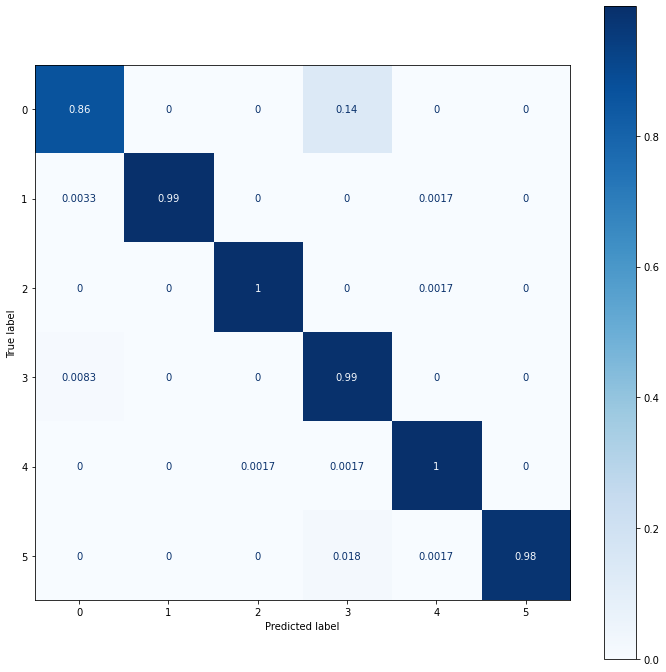

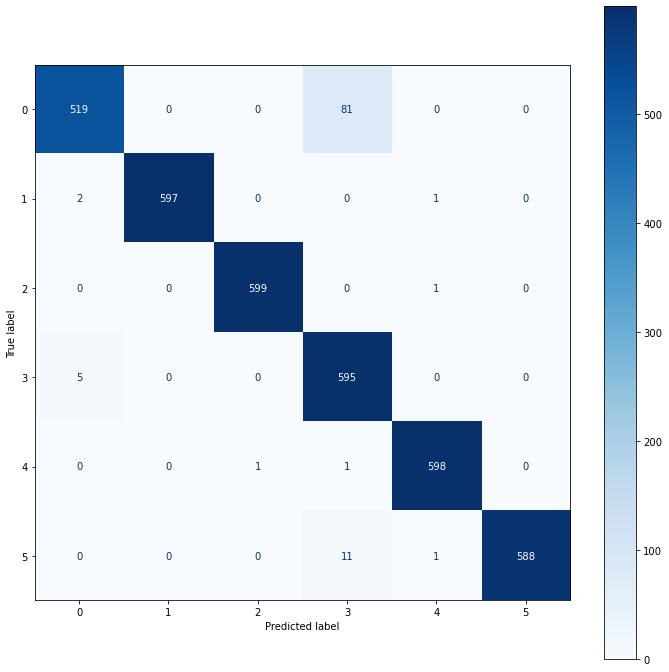



Class 0:
    Sensitivity (TPR):  86.500% (519 of 600)
    Specificity (TNR):  99.767% (2993 of 3000)
    Precision:          98.669% (519 of 526)
    Neg. pred. value:   97.365% (2993 of 3074)
Class 1:
    Sensitivity (TPR):  99.500% (597 of 600)
    Specificity (TNR): 100.000% (3000 of 3000)
    Precision:         100.000% (597 of 597)
    Neg. pred. value:   99.900% (3000 of 3003)
Class 2:
    Sensitivity (TPR):  99.833% (599 of 600)
    Specificity (TNR):  99.967% (2999 of 3000)
    Precision:          99.833% (599 of 600)
    Neg. pred. value:   99.967% (2999 of 3000)
Class 3:
    Sensitivity (TPR):  99.167% (595 of 600)
    Specificity (TNR):  96.900% (2907 of 3000)
    Precision:          86.483% (595 of 688)
    Neg. pred. value:   99.828% (2907 of 2912)
Class 4:
    Sensitivity (TPR):  99.667% (598 of 600)
    Specificity (TNR):  99.900% (2997 of 3000)
    Precision:          99.501% (598 of 601)
    Neg. pred. value:   99.933% (2997 of 2999)
Class 5:
    Sensitivity (TPR):  

In [51]:
best_model = tf.keras.models.load_model(model_resnet_name)
test_model(best_model, test_gen, num_classes)

# Even Smaller Dataset (1000 images per class) 

### Load Data

In [52]:
train_dir = './splitted_data_3/train'
val_dir   = './splitted_data_3/val'
test_dir  = './splitted_data_3/test'

In [53]:
train_gen = get_data_from_gen(image_data_gen, train_dir)
val_gen   = get_data_from_gen(image_data_gen, val_dir, False)
test_gen  = get_data_from_gen(image_data_gen, test_dir, False )

train_gen_preproc = get_data_from_gen(image_data_gen_preproc, train_dir)
val_gen_preproc   = get_data_from_gen(image_data_gen_preproc, val_dir, False)
test_gen_preproc  = get_data_from_gen(image_data_gen_preproc, test_dir, False )

Found 4200 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 4200 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


### Train Model

Epoch 1/30
17/17 [==============================] - 61s 4s/step - loss: 0.0381 - accuracy: 0.9998 - val_loss: 0.0593 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 2/30
17/17 [==============================] - 5s 321ms/step - loss: 0.0296 - accuracy: 0.9998 - val_loss: 0.0633 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 3/30
17/17 [==============================] - 6s 332ms/step - loss: 0.0292 - accuracy: 0.9995 - val_loss: 0.0714 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 4/30
17/17 [==============================] - 5s 306ms/step - loss: 0.0342 - accuracy: 0.9998 - val_loss: 0.0743 - val_accuracy: 0.9989 - lr: 1.0000e-05


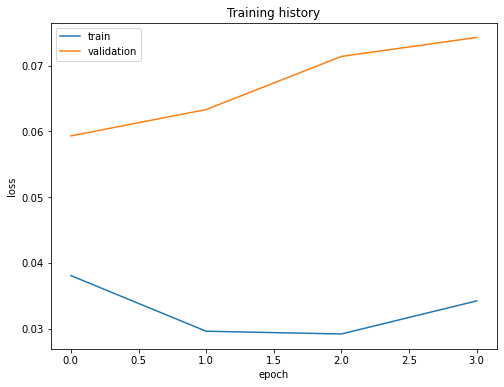

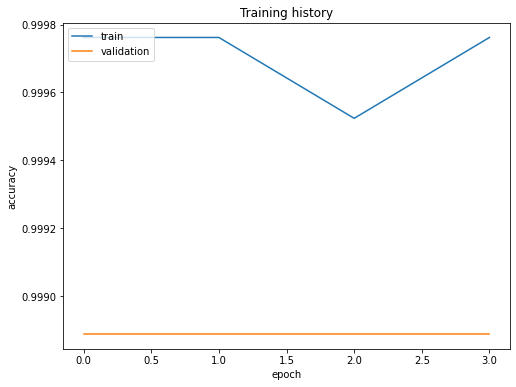

In [54]:
train_model(model_simple, model_simple_name, train_gen, val_gen)

Epoch 1/30
17/17 [==============================] - 6s 342ms/step - loss: 0.0014 - accuracy: 0.9993 - val_loss: 5.5146e-05 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/30
17/17 [==============================] - 5s 285ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 5.4872e-05 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/30
17/17 [==============================] - 5s 309ms/step - loss: 3.3408e-04 - accuracy: 0.9998 - val_loss: 5.5027e-05 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/30
17/17 [==============================] - 5s 302ms/step - loss: 5.0037e-04 - accuracy: 0.9998 - val_loss: 5.4796e-05 - val_accuracy: 1.0000 - lr: 1.0000e-05


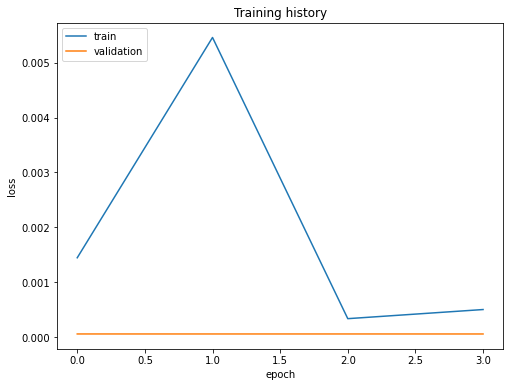

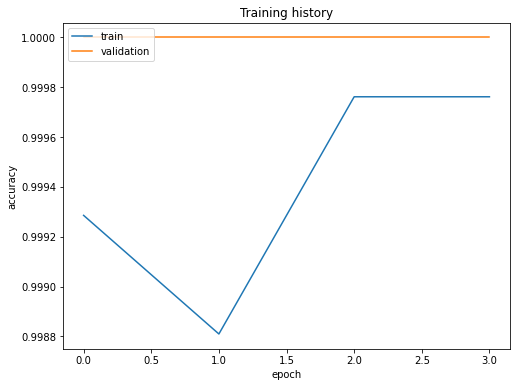

In [55]:
train_model(model_medium, model_medium_name, train_gen, val_gen)

Epoch 1/30
17/17 [==============================] - 8s 446ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 1.0000 - lr: 2.0000e-04
Epoch 2/30
17/17 [==============================] - 6s 363ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0056 - val_accuracy: 0.9978 - lr: 2.0000e-04
Epoch 3/30
17/17 [==============================] - 6s 377ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0035 - val_accuracy: 0.9978 - lr: 2.0000e-04
Epoch 4/30
17/17 [==============================] - 6s 370ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.0024 - val_accuracy: 0.9978 - lr: 4.0000e-05


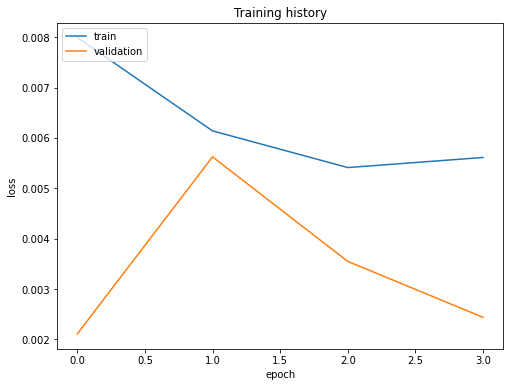

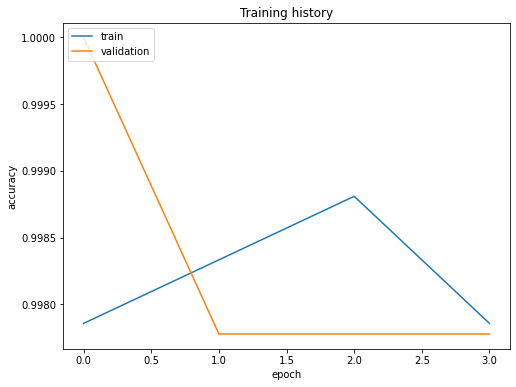

In [56]:
train_model(model_complex, model_complex_name, train_gen, val_gen)

Epoch 1/30
17/17 [==============================] - 10s 601ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0191 - val_accuracy: 0.9956 - lr: 1.0000e-05
Epoch 2/30
17/17 [==============================] - 7s 393ms/step - loss: 0.0274 - accuracy: 0.9905 - val_loss: 0.0189 - val_accuracy: 0.9956 - lr: 1.0000e-05
Epoch 3/30
17/17 [==============================] - 6s 382ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0191 - val_accuracy: 0.9956 - lr: 1.0000e-05
Epoch 4/30
17/17 [==============================] - 7s 383ms/step - loss: 0.0271 - accuracy: 0.9910 - val_loss: 0.0188 - val_accuracy: 0.9956 - lr: 1.0000e-05


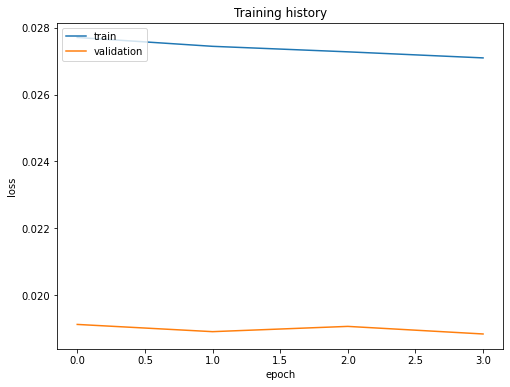

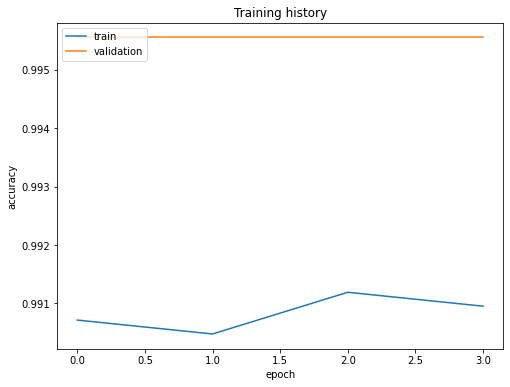

In [57]:
train_model(model_resnet, model_resnet_name, train_gen_preproc, val_gen_preproc)

### Test Model

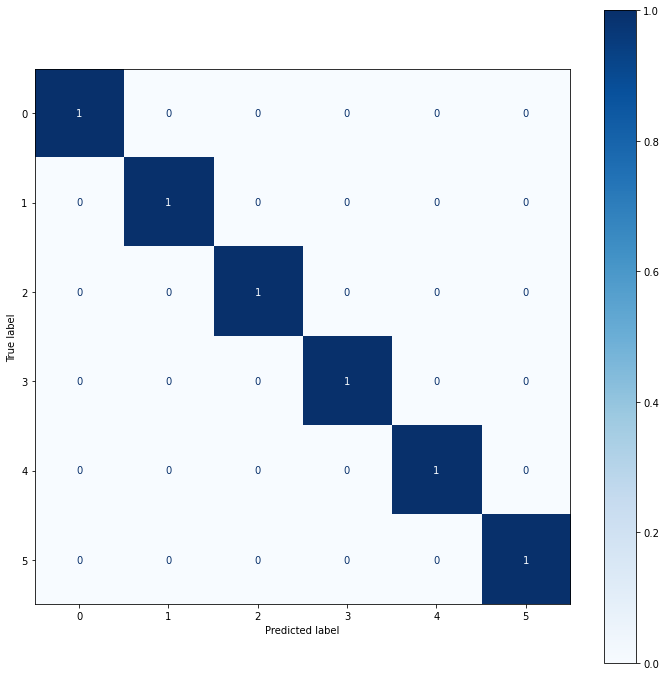

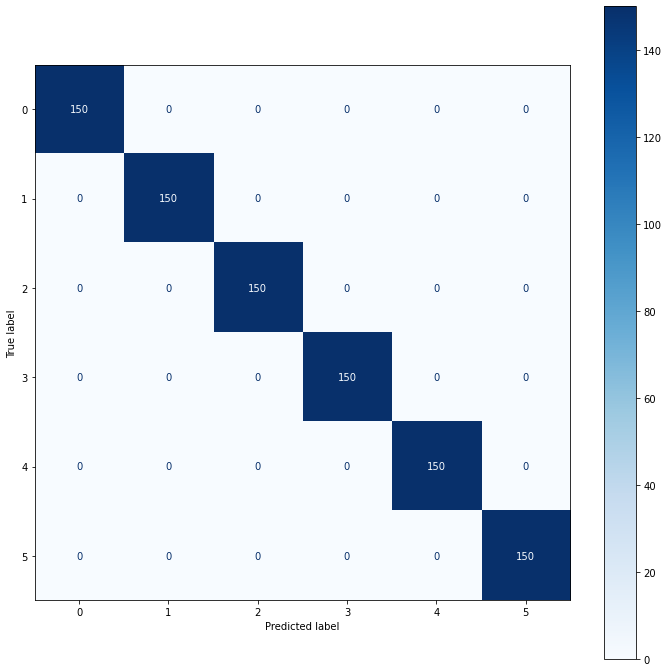



Class 0:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 1:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 2:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 3:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 4:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 5:
    Sensitivity (TPR): 100.000% (150 of 150)

In [58]:
best_model = tf.keras.models.load_model(model_simple_name)
test_model(best_model, test_gen, num_classes)

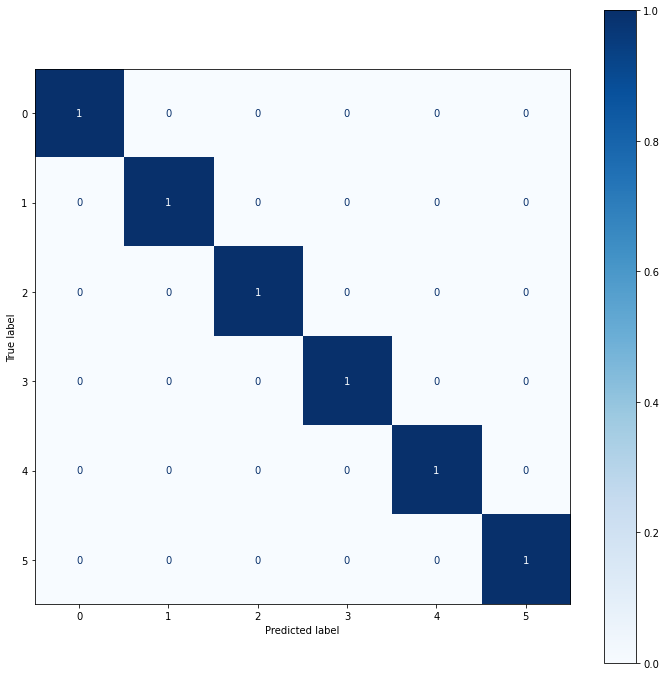

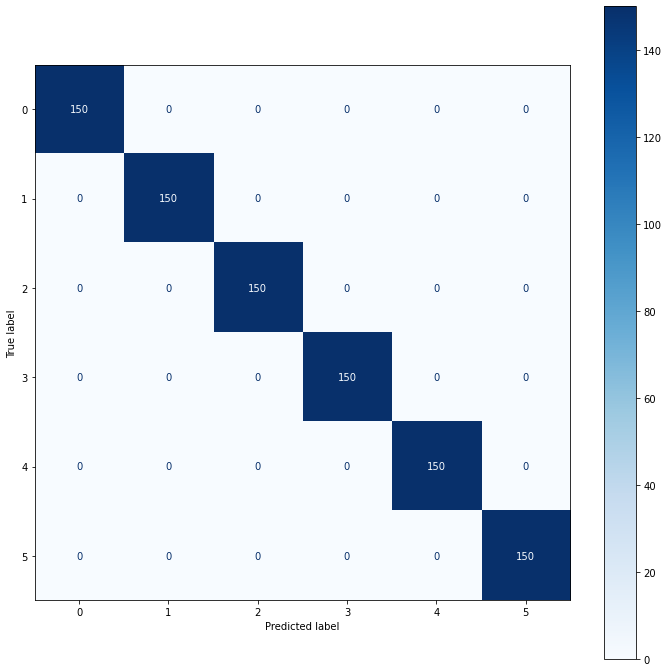



Class 0:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 1:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 2:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 3:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 4:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 5:
    Sensitivity (TPR): 100.000% (150 of 150)

In [59]:
best_model = tf.keras.models.load_model(model_medium_name)
test_model(best_model, test_gen, num_classes)

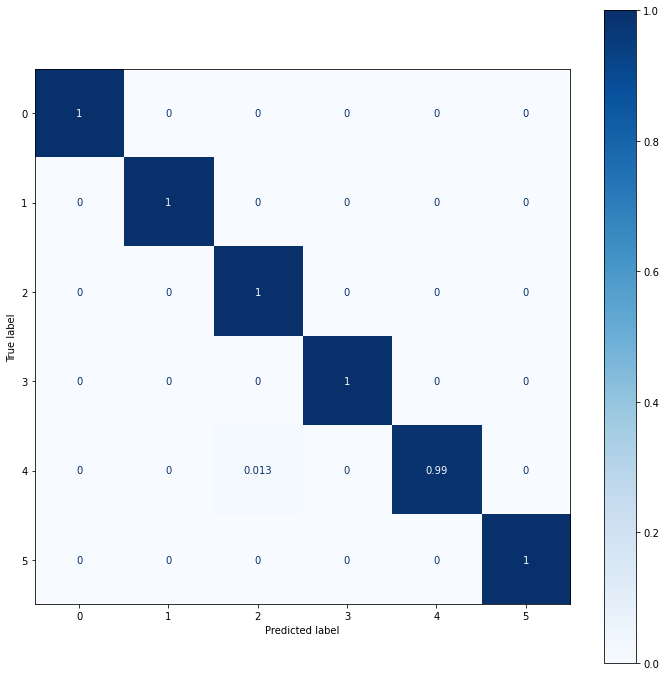

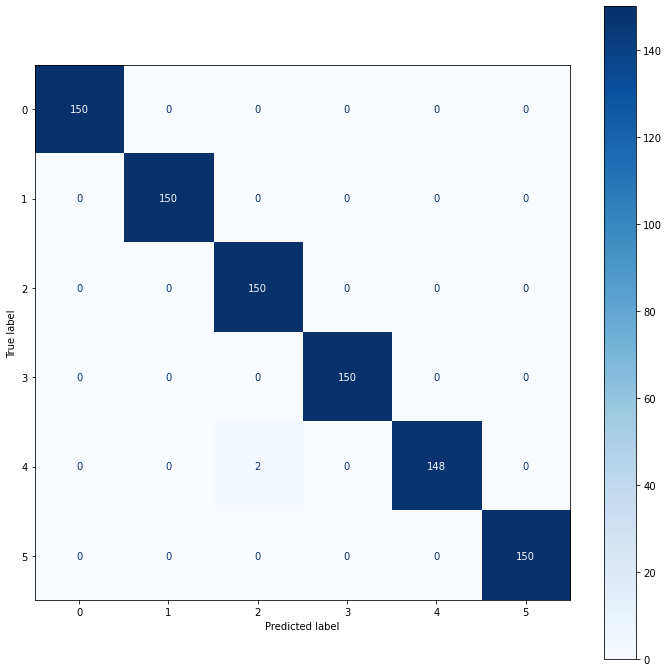



Class 0:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 1:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 2:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR):  99.733% (748 of 750)
    Precision:          98.684% (150 of 152)
    Neg. pred. value:  100.000% (748 of 748)
Class 3:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 4:
    Sensitivity (TPR):  98.667% (148 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (148 of 148)
    Neg. pred. value:   99.734% (750 of 752)
Class 5:
    Sensitivity (TPR): 100.000% (150 of 150)

In [60]:
best_model = tf.keras.models.load_model(model_complex_name)
test_model(best_model, test_gen, num_classes)

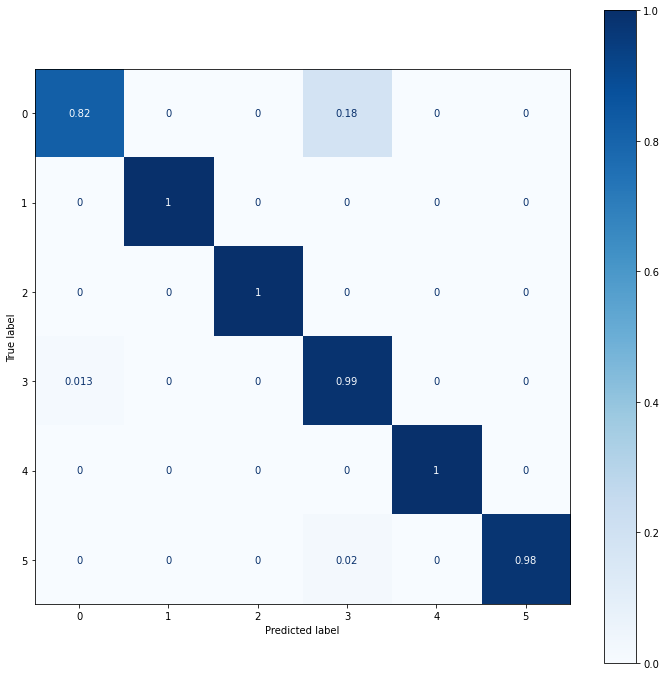

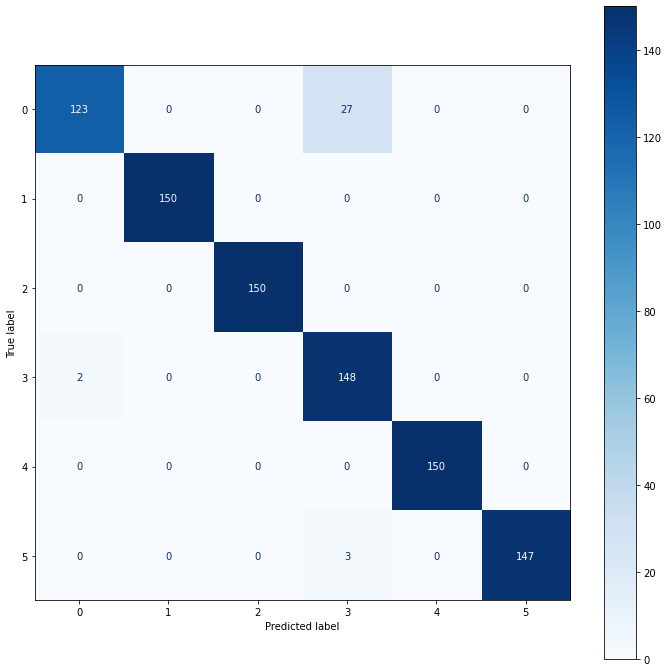



Class 0:
    Sensitivity (TPR):  82.000% (123 of 150)
    Specificity (TNR):  99.733% (748 of 750)
    Precision:          98.400% (123 of 125)
    Neg. pred. value:   96.516% (748 of 775)
Class 1:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 2:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 3:
    Sensitivity (TPR):  98.667% (148 of 150)
    Specificity (TNR):  96.000% (720 of 750)
    Precision:          83.146% (148 of 178)
    Neg. pred. value:   99.723% (720 of 722)
Class 4:
    Sensitivity (TPR): 100.000% (150 of 150)
    Specificity (TNR): 100.000% (750 of 750)
    Precision:         100.000% (150 of 150)
    Neg. pred. value:  100.000% (750 of 750)
Class 5:
    Sensitivity (TPR):  98.000% (147 of 150)

In [61]:
best_model = tf.keras.models.load_model(model_resnet_name)
test_model(best_model, test_gen, num_classes)

# Very Small Dataset (100 images per class) 

### Load Data

In [62]:
train_dir = './splitted_data_4/train'
val_dir   = './splitted_data_4/val'
test_dir  = './splitted_data_4/test'

In [63]:
train_gen = get_data_from_gen(image_data_gen, train_dir)
val_gen   = get_data_from_gen(image_data_gen, val_dir, False)
test_gen  = get_data_from_gen(image_data_gen, test_dir, False )

train_gen_preproc = get_data_from_gen(image_data_gen_preproc, train_dir)
val_gen_preproc   = get_data_from_gen(image_data_gen_preproc, val_dir, False)
test_gen_preproc  = get_data_from_gen(image_data_gen_preproc, test_dir, False )

Found 420 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


### Train Model

Epoch 1/30
2/2 [==============================] - 2s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/30
2/2 [==============================] - 1s 274ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/30
2/2 [==============================] - 1s 298ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/30
2/2 [==============================] - 0s 225ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05


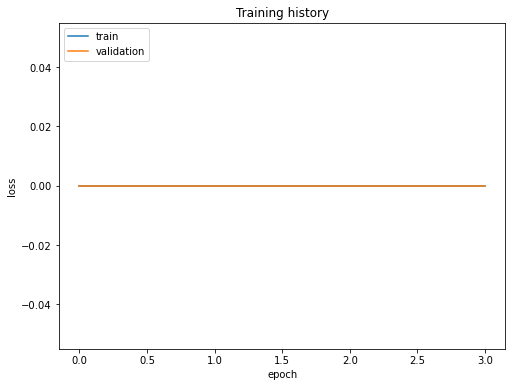

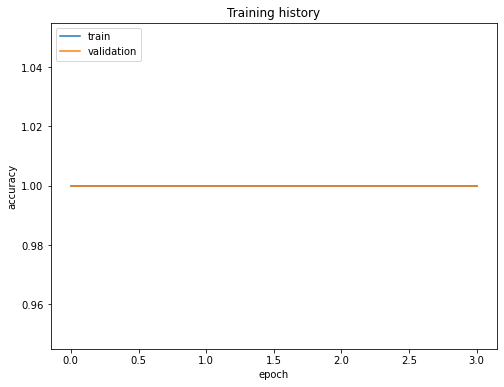

In [64]:
train_model(model_simple, model_simple_name, train_gen, val_gen)

Epoch 1/30
2/2 [==============================] - 1s 665ms/step - loss: 0.0712 - accuracy: 0.9976 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/30
2/2 [==============================] - 1s 323ms/step - loss: 1.1659e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/30
2/2 [==============================] - 1s 381ms/step - loss: 5.1034e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/30
2/2 [==============================] - 1s 273ms/step - loss: 6.8977e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-05


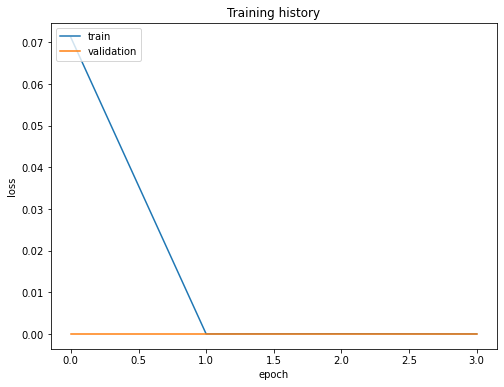

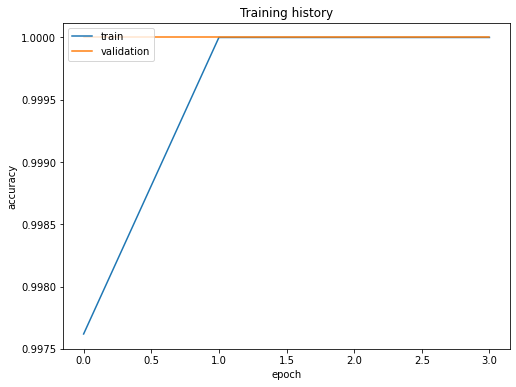

In [65]:
train_model(model_medium, model_medium_name, train_gen, val_gen)

Epoch 1/30
2/2 [==============================] - 1s 514ms/step - loss: 0.0079 - accuracy: 0.9952 - val_loss: 5.4461e-05 - val_accuracy: 1.0000 - lr: 4.0000e-05
Epoch 2/30
2/2 [==============================] - 0s 249ms/step - loss: 0.0125 - accuracy: 0.9929 - val_loss: 5.4991e-05 - val_accuracy: 1.0000 - lr: 4.0000e-05
Epoch 3/30
2/2 [==============================] - 1s 317ms/step - loss: 0.0040 - accuracy: 0.9976 - val_loss: 5.9921e-05 - val_accuracy: 1.0000 - lr: 4.0000e-05
Epoch 4/30
2/2 [==============================] - 1s 332ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 6.1126e-05 - val_accuracy: 1.0000 - lr: 1.0000e-05


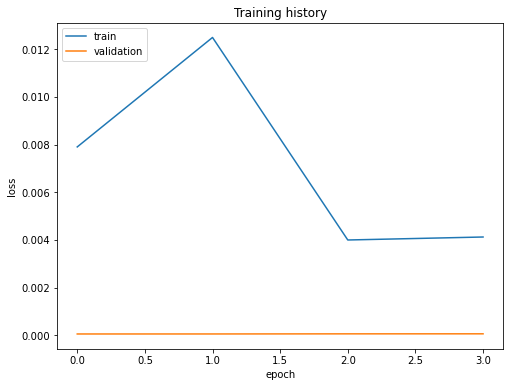

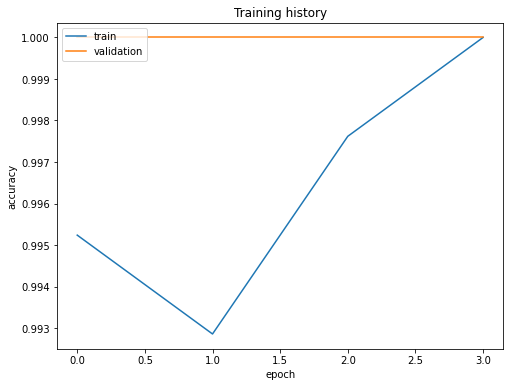

In [66]:
train_model(model_complex, model_complex_name, train_gen, val_gen)

Epoch 1/30
2/2 [==============================] - 3s 2s/step - loss: 0.0185 - accuracy: 0.9976 - val_loss: 0.0253 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/30
2/2 [==============================] - 1s 406ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.0249 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/30
2/2 [==============================] - 1s 345ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0243 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/30
2/2 [==============================] - 1s 367ms/step - loss: 0.0178 - accuracy: 0.9952 - val_loss: 0.0235 - val_accuracy: 1.0000 - lr: 1.0000e-05


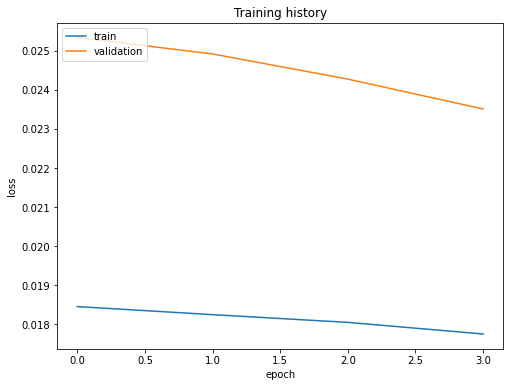

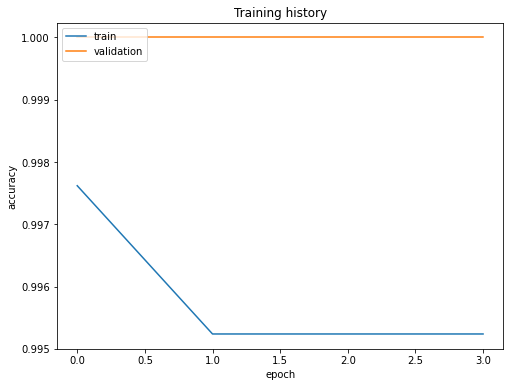

In [67]:
train_model(model_resnet, model_resnet_name, train_gen_preproc, val_gen_preproc)

### Test Model

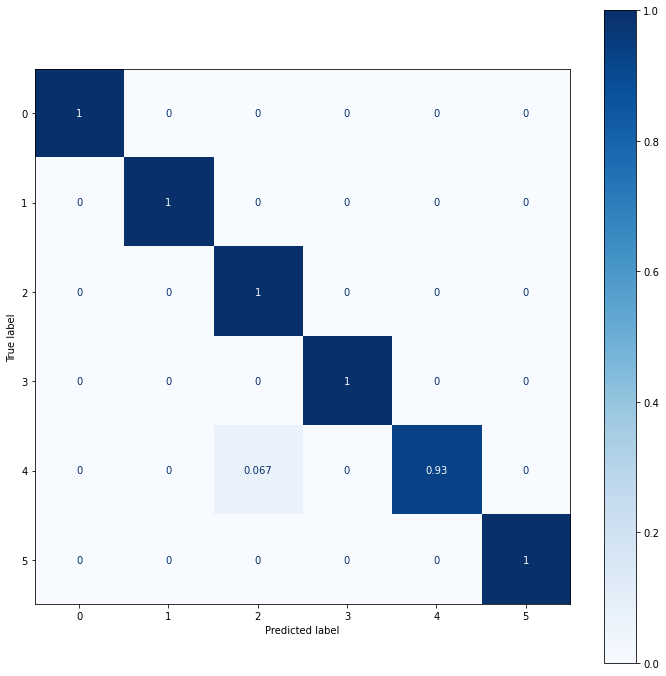

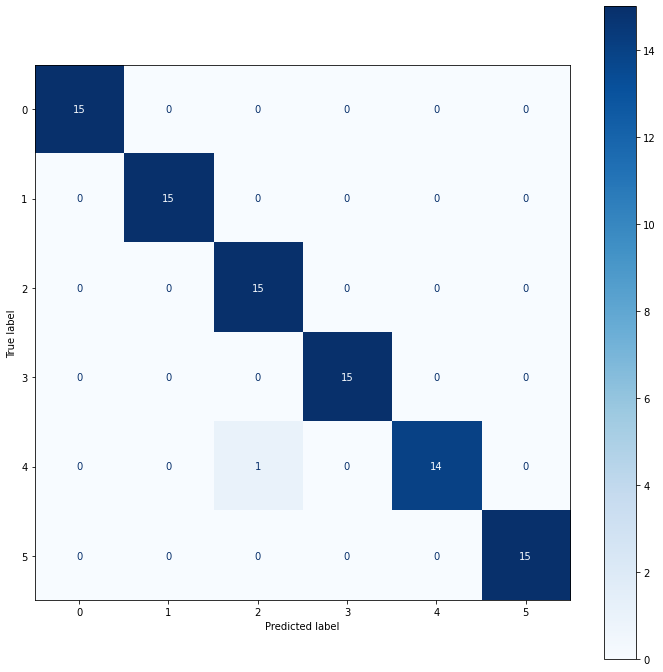



Class 0:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 1:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 2:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR):  98.667% (74 of 75)
    Precision:          93.750% (15 of 16)
    Neg. pred. value:  100.000% (74 of 74)
Class 3:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 4:
    Sensitivity (TPR):  93.333% (14 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (14 of 14)
    Neg. pred. value:   98.684% (75 of 76)
Class 5:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75

In [68]:
best_model = tf.keras.models.load_model(model_simple_name)
test_model(best_model, test_gen, num_classes)

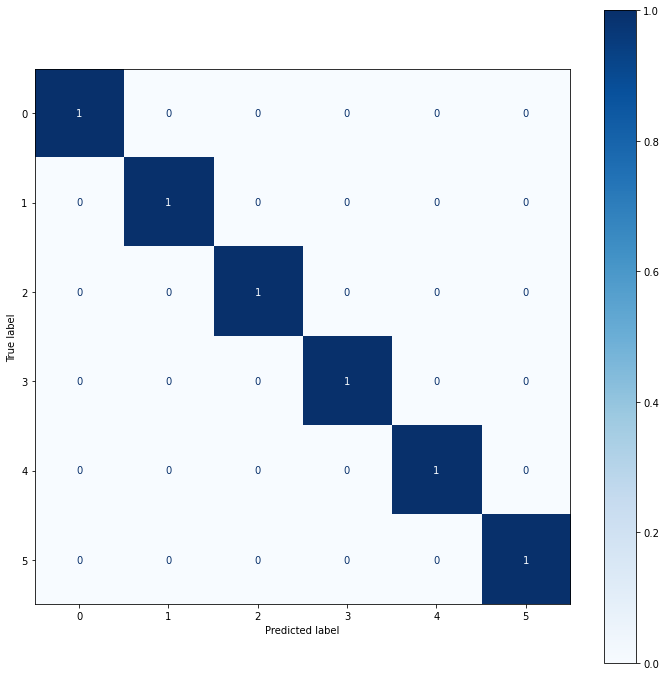

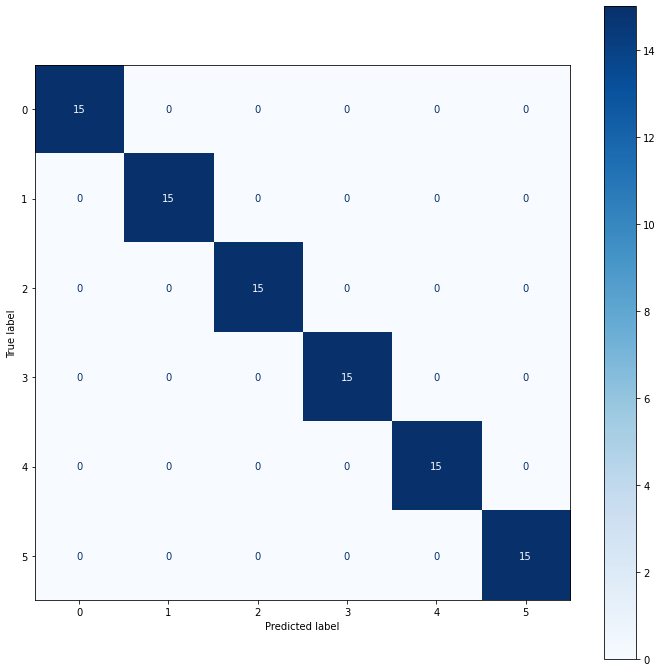



Class 0:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 1:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 2:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 3:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 4:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 5:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75

In [69]:
best_model = tf.keras.models.load_model(model_medium_name)
test_model(best_model, test_gen, num_classes)

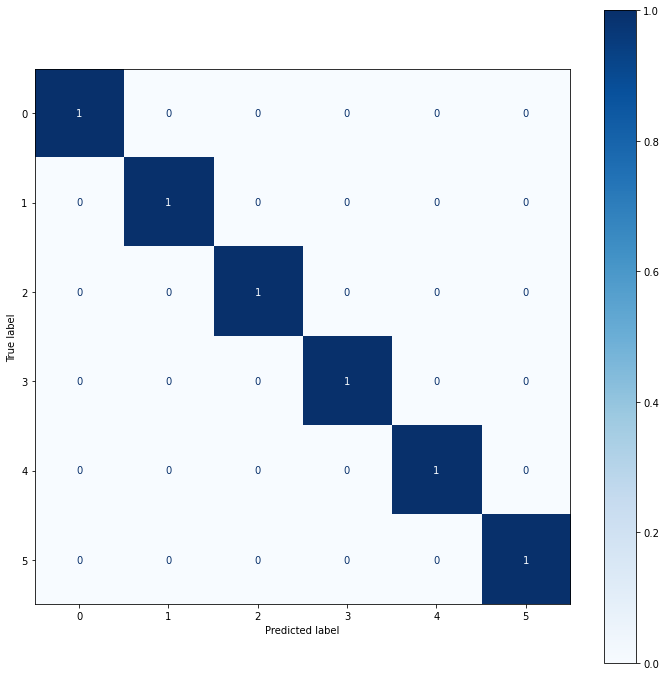

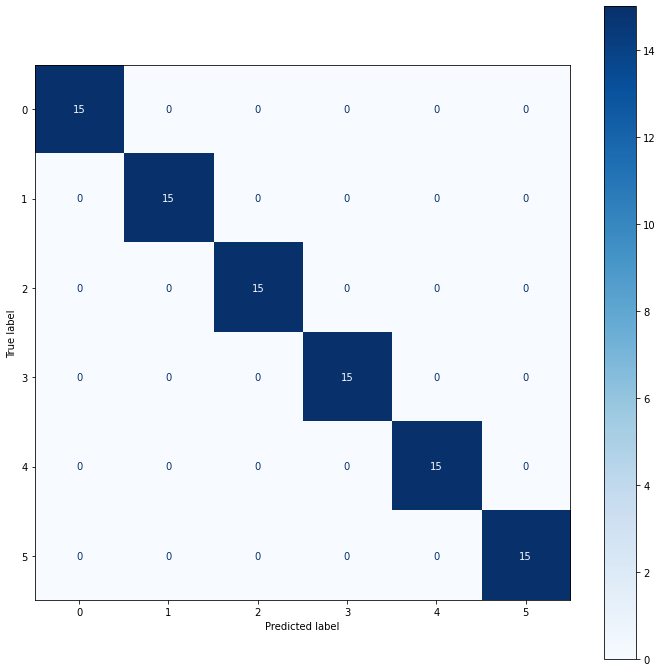



Class 0:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 1:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 2:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 3:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 4:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 5:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75

In [70]:
best_model = tf.keras.models.load_model(model_complex_name)
test_model(best_model, test_gen, num_classes)

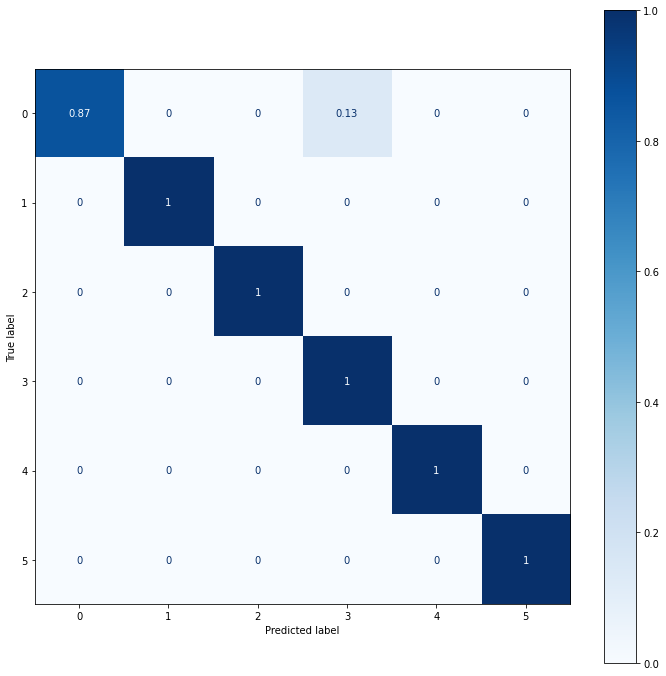

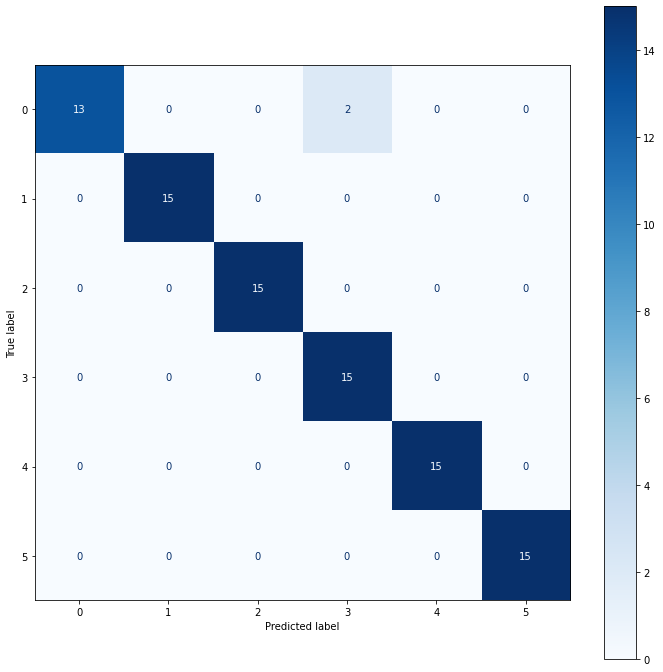



Class 0:
    Sensitivity (TPR):  86.667% (13 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (13 of 13)
    Neg. pred. value:   97.403% (75 of 77)
Class 1:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 2:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 3:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR):  97.333% (73 of 75)
    Precision:          88.235% (15 of 17)
    Neg. pred. value:  100.000% (73 of 73)
Class 4:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75)
    Precision:         100.000% (15 of 15)
    Neg. pred. value:  100.000% (75 of 75)
Class 5:
    Sensitivity (TPR): 100.000% (15 of 15)
    Specificity (TNR): 100.000% (75 of 75

In [71]:
best_model = tf.keras.models.load_model(model_resnet_name)
test_model(best_model, test_gen, num_classes)

# Conclusio

- All tested neural networks have achieved very good results
    - Accuracy >90% was already achieved after the first epoch
- However, the two smaller networks (especially model_medium) achieved overall better results
- Surprisingly, even the more complex models achieved an accuracy >97% with fewer data samples
    - even if no overfitting occurred in this project, the probability is very high that one does occur
- Therefore, simpler models (with fewer parameters) should always be considered as well, since they often achieve very good results -> it does not always have to be a very big and complex model